In [8]:
import numpy as np
import pandas as pd

import scipy as sp
from scipy import linalg as la
from scipy import optimize
from scipy import stats
from scipy.stats import chisquare

import matplotlib.pyplot as plt
import matplotlib as mpl


In [9]:
file = 'SouthCalifornia-1982-2011_Physics-of-Data.dat'
data = np.genfromtxt(file,
                     dtype=None,
                     delimiter=' ')
data.shape

(110271,)

In [10]:
df = pd.DataFrame(data)
df.columns = ['event', 'prev_event', 'time', 'magnitude', 'x', 'y', 'z']

# 0 - Understanding data

First of all we took a look at the dataset.

In [11]:
df.head()

,event,prev_event,time,magnitude,x,y,z
0,0,-1,0.00000,2.71,-2571956,-4627162,3520602
1,1,0,36501.39072,2.12,-2363740,-4787011,3461373
2,2,0,37488.27744,2.33,-2363746,-4786942,3461232
3,3,0,47982.51648,2.57,-2475085,-4664024,3548479
4,4,0,60268.57056,2.98,-2238642,-4839098,3469546


In [12]:
# we can see that the range of magnitudes is [2,7.3] 
# and that the measurement of time starts from 0 with the first event
df.describe()

,event,prev_event,time,magnitude,x,y,z
count,110271.000000,110271.000000,1.102710e+05,110271.000000,1.102710e+05,1.102710e+05,1.102710e+05
mean,55135.000000,35859.277625,4.262426e+08,2.457920,-2.388225e+06,-4.691072e+06,3.562612e+06
std,31832.640104,36365.001297,2.598605e+08,0.438374,8.878019e+04,1.237294e+05,1.271897e+05
min,0.000000,-1.000000,0.000000e+00,2.000000,-2.770239e+06,-5.020849e+06,3.186133e+06
25%,27567.500000,-1.000000,2.115783e+08,2.140000,-2.421620e+06,-4.801152e+06,3.458838e+06
50%,55135.000000,28462.000000,3.551023e+08,2.340000,-2.361829e+06,-4.699729e+06,3.564367e+06
75%,82702.500000,66972.000000,5.952398e+08,2.640000,-2.329898e+06,-4.615062e+06,3.634552e+06
max,110270.000000,110250.000000,9.305667e+08,7.300000,-1.998294e+06,-4.268289e+06,3.876120e+06


In [13]:
# not all the greatest earthquakes are without ancestors (we shall call them 'prime events')
df[df['magnitude']>6].sort_values(by = 'magnitude', ascending = False)

,event,prev_event,time,magnitude,x,y,z
39805,39805,39804,3.309144e+08,7.30,-2341818,-4710335,3575181
100065,100065,100062,8.915162e+08,7.20,-2294542,-4855348,3390238
75422,75422,75419,5.612489e+08,7.10,-2316706,-4693410,3609984
58367,58367,-1,3.799916e+08,6.70,-2508327,-4610300,3567642
22089,22089,21867,1.859399e+08,6.60,-2322573,-4795291,3462353
89331,89331,-1,6.932159e+08,6.48,-2662869,-4420508,3708948
39859,39859,39858,3.309257e+08,6.30,-2373276,-4692488,3573922
21867,21867,21866,1.858990e+08,6.20,-2316585,-4796535,3470023
37455,37455,37449,3.251864e+08,6.10,-2335795,-4723356,3549940
55532,55532,-1,3.588626e+08,6.10,-2364815,-4481227,3839436


# 1 - Data visualization

## 1.1 - Time distribution

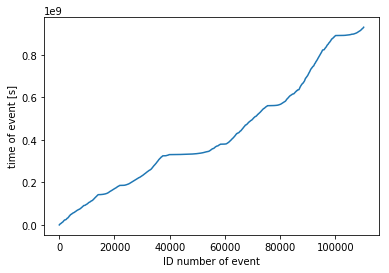

In [14]:
# just a routine look at the time distribution and time scale of the dataset 
%matplotlib inline

plt.plot(df['event'], df['time'])
plt.xlabel('ID number of event')
plt.ylabel('time of event [s]')
plt.show()

## 1.2 - Magnitude distribution

In [15]:
def my_expon(x, No, alpha):
    return No*np.exp(-alpha*x)

def my_log_expon(x, Q, alpha):
    return -alpha*x + Q

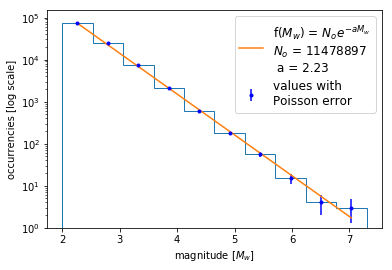

In [16]:
# here we can see how the magnitude is distributed as exp(-m)
n, bins, _ = plt.hist(df['magnitude'], log = True, histtype = 'step')
bin_centers = (bins[1:] + bins[:-1])/2
plt.errorbar(bin_centers, n, np.sqrt(n), fmt = '.b', label = 'values with \nPoisson error')

params1, _ = optimize.curve_fit(my_log_expon, bin_centers, np.log(n))
[Q, alpha] = params1
No = int(np.exp(Q))
plt.plot(bin_centers, my_expon(bin_centers, No, alpha), 
         label = 'f($M_w$) = $N_o$$e^{-aM_w}$ '+'\n$N_o$ = {}\n a = {}'.format(No,round(alpha,2)))

plt.xlabel('magnitude [$M_w$]')
plt.ylabel('occurrencies [log scale]')
plt.ylim(bottom = 1)
plt.legend(fontsize = 12)
plt.show()
plt.close()

# ADD NON LOGSCALE PLOT

## 1.3 - Spatial distribution 

In [17]:
from mpl_toolkits.mplot3d import Axes3D

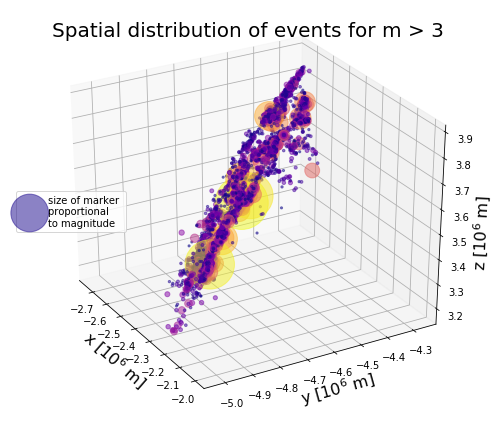

In [18]:
#az = [i*15 for i in range(24)]
#for azim in az:
#%matplotlib nbagg
m_bar = 3
dfm = df[df['magnitude'] > m_bar]
x_coord = dfm['x']
y_coord = dfm['y']
z_coord = dfm['z']
magnitude = dfm['magnitude']

fig = plt.figure(figsize = (7,6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_coord/1e06, y_coord/1e06, z_coord/1e06, 
           s=np.exp(magnitude*1.5)/np.exp(3), c = magnitude, marker="o", alpha = 0.5, 
           label = 'size of marker \nproportional \nto magnitude', cmap = 'plasma')
ax.set_xlabel("x [$10^6$ m]", fontsize = 16)
ax.set_ylabel("y [$10^6$ m]", fontsize = 16)
ax.set_zlabel("z [$10^6$ m]", fontsize = 16)
ax.set_title('Spatial distribution of events for m > 3', fontsize = 20)
ax.legend(loc = 'center left')
#print('azim = ', azim)
ax.view_init(elev = 30, azim = 330)

for spine in ax.spines.values():
    spine.set_visible(False)
    
plt.tight_layout()
plt.show()

### 1.3.1 PCA for spatial distribution

In [19]:
X = df[['x','y','z']].values.T
X = X.astype("float64")

# centering and rescaling the coordinates
for i in range(3):
    X[i] = (X[i] - X[i].mean())/X[i].std()

In [20]:
# PCA 
C = np.cov(X)
U, spectrum, Vt = la.svd(C)
print ('Spectrum: ', spectrum,'\n')
perc_expl2 = (spectrum[0] + spectrum[1]) / spectrum.sum()
print('Percent of the total variability explained considering the two main features: ', perc_expl2, '\n')

Spectrum:  [2.40189791e+00 5.96194962e-01 1.93433620e-03] 

Percent of the total variability explained considering the two main features:  0.9993552271146224 



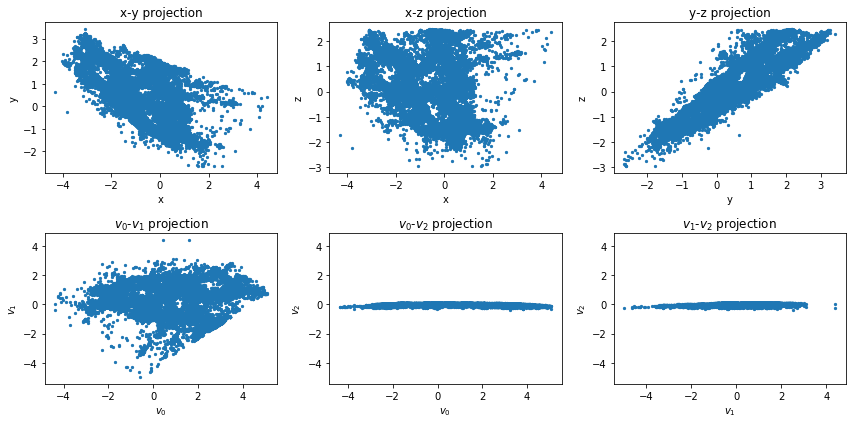

In [21]:
# projecting the data in the plane generated by the two eigenvectors with the largest eigenvalues
Xp = np.dot(Vt,X)

%matplotlib inline
# general plot of the PCA
fig, axes = plt.subplots(nrows=2, ncols=3,
                               figsize=(12, 6))

[[ax01, ax02, ax03],[ax11, ax12, ax13]] = axes

ax01.scatter(X[0], X[1], s= 5)
ax01.set_title('x-y projection')
ax01.set_xlabel('x')
ax01.set_ylabel('y')

ax02.scatter(X[0], X[2], s= 5)
ax02.set_title('x-z projection')
ax02.set_xlabel('x')
ax02.set_ylabel('z')

ax03.scatter(X[1], X[2], s= 5)
ax03.set_title('y-z projection')
ax03.set_xlabel('y')
ax03.set_ylabel('z')

ax11.scatter(Xp[0], Xp[1], s= 5)
ax11.set_title('$v_0$-$v_1$ projection')
(y_bottom, y_top) = ax11.get_ylim()
ax11.set_xlabel('$v_0$')
ax11.set_ylabel('$v_1$')

ax12.scatter(Xp[0], Xp[2], s= 5)
ax12.set_ylim(y_bottom, y_top)
ax12.set_title('$v_0$-$v_2$ projection')
ax12.set_xlabel('$v_0$')
ax12.set_ylabel('$v_2$')

ax13.scatter(Xp[1], Xp[2], s= 5)
ax13.set_ylim(y_bottom, y_top)
ax13.set_title('$v_1$-$v_2$ projection')
ax13.set_xlabel('$v_1$')
ax13.set_ylabel('$v_2$')

plt.tight_layout()
plt.show()

# ABBELLIRE
# KDE

In [ ]:
import seaborn as sns
# Show the joint distribution using kernel density estimation
g = sns.jointplot(Xp[0], Xp[1], kind="kde", xlim=[-4,4], ylim=[-4,4], height=7, space=0)
g.set_axis_labels(xlabel='x', ylabel='y')

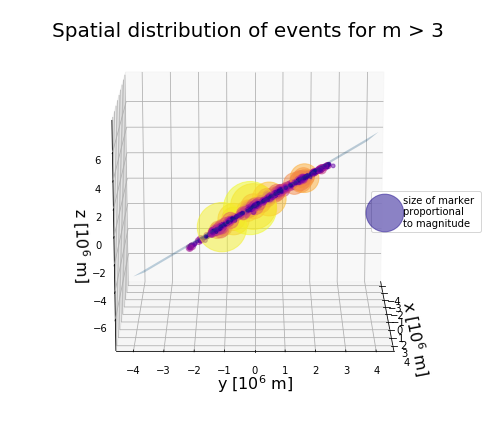

In [22]:
[v1, v2, v3] = Vt
normal = v3
xx, yy = np.meshgrid(range(-4,5), range(-4,5))# calculate corresponding z
z = (-normal[0] * xx - normal[1] * yy ) * 1. /normal[2]

m_bar = 3
dfm = df[df['magnitude'] > m_bar]
x_coord = dfm['x']
y_coord = dfm['y']
z_coord = dfm['z']
x_coord = (x_coord - x_coord.mean())/x_coord.std()
y_coord = (y_coord - y_coord.mean())/y_coord.std()
z_coord = (z_coord - z_coord.mean())/z_coord.std()
magnitude = dfm['magnitude']

#%matplotlib nbagg

fig = plt.figure(figsize = (7,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(xx, yy, z, alpha=0.3)
ax.scatter(x_coord, y_coord, z_coord, 
           s=np.exp(magnitude*1.5)/np.exp(3), c = magnitude, marker="o", alpha = 0.5, 
           label = 'size of marker \nproportional \nto magnitude', cmap = 'plasma')
ax.set_xlabel("x [$10^6$ m]", fontsize = 16)
ax.set_ylabel("y [$10^6$ m]", fontsize = 16)
ax.set_zlabel("z [$10^6$ m]", fontsize = 16)
ax.set_title('Spatial distribution of events for m > 3', fontsize = 20)
ax.legend(loc = 'center right')
#print('azim = ', azim)
ax.view_init(elev = 15, azim = 0)
for spine in ax.spines.values():
    spine.set_visible(False)

plt.tight_layout()
plt.show()

In [23]:
plt.close()
%matplotlib inline

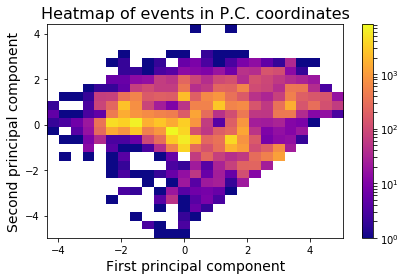

In [24]:
from matplotlib.colors import LogNorm
plt.figure(211)

# farlo in 3D con le barre?
plt.hist2d(Xp[0], Xp[1], bins = 25, norm = LogNorm(), cmap = "plasma")
plt.colorbar()
plt.xlabel('First principal component', fontsize = 14)
plt.ylabel('Second principal component', fontsize = 14)
plt.title('Heatmap of events in P.C. coordinates', fontsize = 16)
plt.tight_layout()
plt.show()
plt.close()

# più fine?

## 1.4 - Tree architecture

Here we want to exploit the information contained in the 'prev_event' column in order to be able to compute quantities such as distance and waiting time between an event and his ancestor.

First of all we iteratively created a nested dictionary, containing as keys the IDs of the primes events (i.e. the ones labelled with 'prev_event' = 1) and as values a dictionary with:
* the "depth" of the event in the cause-effect chain (i.e. 0 for the prime events, 1 for the ones caused by them, 2 for the ones caused by events of depth 1 and so on so forth);
* the "children" of that event, i.e. the events that have as prev_event the id of the event considered; "children" value contains itself a dictionary like the one just described for the prime events, hence the nested structure.

In [25]:
def evees_light(df, index=-1, depth=0):
    dataset = {}
    df_filtered = df[df["prev_event"]==index]
    lenght =  df_filtered.shape[0]
    for i in range(lenght):
        event = df_filtered.iloc[i]
        dataset[str(int(event["event"]))] = {"depth" : depth}
        dataset[str(int(event["event"]))]["children"] = evees_light(df, index=int(event["event"]), depth = depth + 1)
    return dataset

Then we mapped the dictionary so obtained in a list of dictionaries, whose indexes are the depth of the events (ranging from 0 to max_depth, that is unknown a priori); the entry of the list of index i is a dictionary that has as keys the IDs of the events of depth = i and as values the IDs of its children.

In [26]:
def write_dict_array(dataset, dict_array):
    for k in dataset.keys():
        depth = dataset[k]['depth']
        # k is the keyword, children_ids are the values
        if len(dict_array) < depth + 1 :
            while len(dict_array) < depth + 1:
                dict_array.append({})
        else:
            dict_array[depth][k] = list(dataset[k]['children'].keys())
        if len(list(dataset[k]['children'].keys())) != 0:
            write_dict_array(dataset[k]['children'], dict_array)

In [27]:
tree_dataset = evees_light(df)
v_dict = [{}]
write_dict_array(tree_dataset, v_dict)

Now we use the list of dictionaries to add the depth and the number of children (or number of edges if we think of the dataset as an oriented graph) of each event by adding two columns to the original dataset.

In [28]:
N = df.shape[0]
edges = np.zeros(N)
depths = np.zeros(N)

for d in range(len(v_dict)):
    for k in v_dict[d].keys():
        #print(k)
        edges[int(k)] = len(v_dict[d][k])
        depths[int(k)] = d
        
df['edges'] = edges
df['depth'] = depths

In [29]:
# From the new features we can see an interesting thing: the event with the highest magnitude (7.3) is not prime 
# (because it hasn't prev_event = -1), but it happend after a concatenation of 11 earthquakes and subsequently caused 
# other 4209 events!
df[df['magnitude'] == 7.3]

,event,prev_event,time,magnitude,x,y,z,edges,depth
39805,39805,39804,3.309144e+08,7.3,-2341818,-4710335,3575181,4209.0,11.0


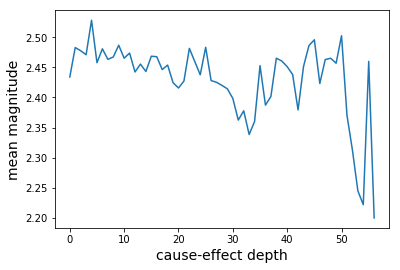

In [30]:
# Furthermore we can see that depth isn't a good indicator of magnitude and that in fact one can't find any relation
# between the two
mean_mag = df.groupby('depth')['magnitude'].mean()
depth_axis = [i for i in range(len(mean_mag))]
plt.plot(depth_axis, mean_mag)
plt.xlabel('cause-effect depth', fontsize = 14)
plt.ylabel('mean magnitude', fontsize = 14)
plt.show()

# va su e giu perché dopo un po sono pochi eventi

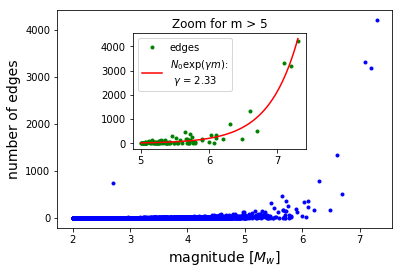

In [31]:
# as we could expect the events with higher magnitudes have much more edges than the ones with lower magnitudes. 
# In fact the dependence is exponential with m

def my_expon1(x, No, gamma):
    return No*np.exp(gamma*x)

plt.plot(df['magnitude'], df['edges'] , '.b')
plt.xlabel('magnitude [$M_w$]', fontsize = 14)
plt.ylabel('number of edges', fontsize = 14)

df5 = df[df['magnitude'] > 5]
ax = plt.axes([0.3, 0.4, 0.4, 0.4])
ax.set_title('Zoom for m > 5')
ax.plot(df5['magnitude'], df5['edges'] , '.g')
params1, _ = optimize.curve_fit(my_expon1, df5['magnitude'], df5['edges'])
[No, gamma] = params1
x_axis = np.linspace(5,7.3,100)
ax.plot(x_axis, my_expon1(x_axis, *params1), 'r-', 
        label = '$N_0$exp($\gamma m$):\n $\gamma$ = {}'.format(round(gamma,2)))
ax.legend()
    
plt.show()

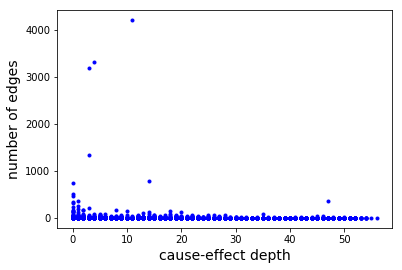

In [32]:
# again depth isn't a good indicator of edges (as it wasn't for magnitude)
plt.plot(df['depth'], df['edges'], 'b.')
plt.xlabel('cause-effect depth', fontsize = 14)
plt.ylabel('number of edges', fontsize = 14)
plt.show()

# 2 - Distribution of waiting time 
Compute the distribution $P_m(t)$ of waiting times for events of magnitude m or above (i.e. do not consider events below $m$). In shaping the bin sizes, take into account that this distribution is expected to have a power-law decay with time (e.g $\sim 1/t$), and that a power-law is well visualized in log-log scale. Do this analysis for many values of $m$, say $m=2,3,4,5$.

In [274]:
def binning(x, rescaling = False, density = False):
    
    """Binning for power laws distributions.
        x = entries generated from a power law."""
    
    # x must have streactly positive values; x isn't normalized in general
    x = x[x>0]
    if rescaling == True:
        x = x/x.max()
        
    x.sort()
    # empirical method to get a good amount of bins (min 8), depending on the number of samples
    bin_extremes_number = max( min( int( np.log(len(x))*2 ) , 17), 9) 
    #print('Bin extremes number chosen: ', bin_extremes_number )
    first_quantile = x[int(x.shape[0]*(1/bin_extremes_number))]
    #print('First quantile: ', first_quantile)
    bin_extremes = np.logspace(np.log10(first_quantile), np.log10(x.max()), bin_extremes_number)
    bin_extremes = np.concatenate((np.array([0]), bin_extremes))

    widths = bin_extremes[1:] - bin_extremes[:-1]
    centers = (bin_extremes[1:] + bin_extremes[:-1])/2
    
    freq, _, _ = plt.hist(x, bins=bin_extremes)
    plt.close()
    
    # weights(bin_center) = Prob(bin_center) if normalized
    weights = freq/widths
    sigma_weights = np.sqrt(freq)/widths
    
    # merging of the first two bins until we get that the first bin represents the max of the PDF
    while weights[0] < weights[1]:
        print('Merging first and second bins.')
        #this is done by removing the second extreme, thus the first bin becomes the one between 0 and 2
        bin_extremes = np.concatenate(([bin_extremes[0]], bin_extremes[2:] ))
        widths = bin_extremes[1:] - bin_extremes[:-1]
        centers = (bin_extremes[1:] + bin_extremes[:-1])/2

        freq, _, _ = plt.hist(x, bins=bin_extremes)
        plt.close()
        weights = freq/widths
        sigma_weights = np.sqrt(freq)/widths
        
    # adding also the merging of empty bins with the one on the left
    # rewrite it in a better form
    mask = (freq != np.zeros(len(freq)))
    flag = np.all(mask)
    #print('All frequencies are non-zero : ', flag)
    # should enter in the while loop only in there is at least one bin without counts in it
    
    while flag == False:
        print('Entered in the while loop')
        print('Original frequencies: ', freq)
        for i in range(1,len(freq)):
            if freq[i] == 0:
                print('Merging bin {} (empty) with bin {}.'.format(i,i-1))
                # bin extremes should be of length len(freq) + 1
                # notice that bin_extremes[i] corresponds to the right border of bin[i-1]
                # bin_extremes[:i] excludes the bin_extreme[i] !
                bin_extremes = np.concatenate((bin_extremes[:i], bin_extremes[i+1:] ))
                widths = bin_extremes[1:] - bin_extremes[:-1]
                centers = (bin_extremes[1:] + bin_extremes[:-1])/2
                # call a break of the for because the len frequence changes and can result in index errors
                break
                
        # update of the frequencies

        freq, _, _ = plt.hist(x, bins=bin_extremes)
        plt.close()
        weights = freq/widths
        sigma_weights = np.sqrt(freq)/widths
        
        mask = (freq != np.zeros(len(freq)))
        flag = np.all(mask)
 
    if density == True:
        #returns normalized weights (with rescaled errors) so that the area of the histogram is 1
        area = np.sum(weights*widths)
        weights = weights / area
        sigma_weights = sigma_weights/area
    
    return bin_extremes, widths, centers, freq, weights, sigma_weights   

In [96]:
def linear_f(x, p, q):
        return p*x+q

def loglog_fitting(x, y, skip_initial_pt = 1, cut_off = False, P0 = 3 ):
    from scipy import optimize

    x = x[skip_initial_pt:]

    y = y[skip_initial_pt:]
    
    if cut_off == False:
        params, cov = optimize.curve_fit(linear_f, x, y)
        [p,q] = params
        return p, q, cov
    
    else:
        #notice that we are already working without considering the first skip_initial_pt points
        mean_squared_res = []    
        predicted_squared_res = []
        
        # P is the number of points considered for the fit, used for testing whether the point P+1 is alligned
        # with them or not; the likelihood of not being alligned is given by the ratio between 
        # the predicted squared residual of point P+1 (based on the fit on the previous P points) 
        # and the mean squared residual computed for the P points 

        #for P in range(3,len(x)):
        # try with 4
        for P in range(P0,len(x)):
            params, cov = optimize.curve_fit(linear_f, x[:P], y[:P])
            [p,q] = params

            squared_residuals = np.power(y[:P] - linear_f(x[:P], *params),2)
            mean_squared_res.append(squared_residuals.mean())
            
            next_pt_squared_res = np.power(y[P] - linear_f(x[P], *params),2) 
            predicted_squared_res.append(next_pt_squared_res)
            
        predicted_squared_res = np.array(predicted_squared_res)
        mean_squared_res = np.array(mean_squared_res)
        predicted_vs_mean_ratio = predicted_squared_res/mean_squared_res
        predicted_vs_mean_ratio_norm = predicted_vs_mean_ratio/predicted_vs_mean_ratio.max()
    
        # The index of the array predicted_vs_mean_ratio_norm is shifted by 3 positions, meaning that we consider
        # as the maximal number of alligned points the one corresponding to the index of the max of 
        # predicted_vs_mean_ratio_norm + 3 = good_points. 
        
        #indexes = np.arange(3,len(x))
        indexes = np.arange(P0,len(x))
        max_index = indexes[predicted_vs_mean_ratio_norm == predicted_vs_mean_ratio_norm.max()]
        good_points = max_index[0]
        print('Good points {} out of {}'.format(good_points, len(x)))
        # Then the cut-off is estimated as x_cut = (x[good_points]+ x[good_points+1])/2
        if good_points < len(x):
            # the -1 shift at the index is because the index numeration starts at 0
            x_cut = (x[good_points-1]+ x[good_points])/2
        else:
            print('ATTENTION: all points seem alligned.')
            print('x_cut set to the value of the last point.')
            x_cut = x[-1]
            
        params, cov = optimize.curve_fit(linear_f, x[:good_points], y[:good_points])
        [p,q] = params
        
        return p, q, cov, x_cut
    

In [170]:
def plot_powerlaw_hist(x, rescaling = False, density = False, show = True, **kwargs):
    
    bin_extremes, widths, centers, freq, weights, sigma_weights = binning(x, rescaling, density)
    bin_number = len(centers)
    
    if show:
        fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2,figsize=(11, 5))

        ax1.hist(centers, bins = bin_extremes, weights = weights, histtype = 'step')
        ax1.errorbar(centers, weights, sigma_weights, fmt = 'r.')
        ax1.set_xscale('log')
        ax1.set_yscale('log')
        ax1.set_xlabel('waiting times [s]', fontsize = 14)
        ax1.set_ylabel('occurrencies', fontsize = 14)
        ax1.set_title('Number of events = {}'.format(len(x)))
    
    # now we need to fit the power law in the log-log space, eventually identifying the points before the cut-off
    # this should work automatically both for the case rescaling = True or False (if True, x is in [0,1]) 
    # and for the case density = True or False (if True, the area of the histogram is normalized to 1 
    # and the weights are rescaled so that np.sum(weights*bin_widths) = 1)
    log_x = np.log(centers)
    log_w = np.log(weights)
    
    # the idea is to write a function that as a default just fits the (log_x,log_w) with a linear function 
    # log_w = p*log_x + q and has 2 flags: one for excluding skip_initial_pt points (set to 1 for default because
    # the first bin is always problematic) and another one to signal that we expect a cut-off at the right side of the
    # distribution (i.e. the tail) and we want to stop fitting just before the cut-off.
    # we want as a return the parameters p and q with their covariance matrix (that is the default return of 
    # scipy curve_fit) and, if the cut_off flag is True, also the estimate cut-off (rescaled or not depending on the 
    # setting passed before)
    
    if 'cut_off' in kwargs:
        if kwargs['cut_off'] == True:
             p, q, cov, log_x_cut = loglog_fitting(log_x, log_w, **kwargs)
    else:
        p, q, cov = loglog_fitting(log_x, log_w, **kwargs)
    
    if show:
        y_errors = sigma_weights/weights

        ax2.errorbar(log_x, log_w, yerr = y_errors ,fmt ='r.', label = 'entries with errors')
        ax2.plot(log_x, linear_f(log_x, p, q), 
                 label = 'f(x) = px + q\np = {} \nq = {}'.format(round(p,1),round(q,1)))
        ax2.legend()
        ax2.set_xlabel('waiting times [logscale]', fontsize = 14)
        ax2.set_ylabel('occurrencies [logscale]', fontsize = 14)

        plt.show()
    
    if 'cut_off' in kwargs:
        if kwargs['cut_off'] == True:
            if rescaling == True:
                return p, q, np.sqrt(cov[0,0]), np.exp(log_x_cut)*x.max()
            else:
                return p, q, np.sqrt(cov[0,0]), np.exp(log_x_cut)
    else:
        # returns the slope, the intercept and the error of the slope
        return p, q, np.sqrt(cov[0,0])


Time distribution for m =  2.0 

Bin extremes number chosen:  17
All frequencies are non-zero :  True
Good points 13 out of 16


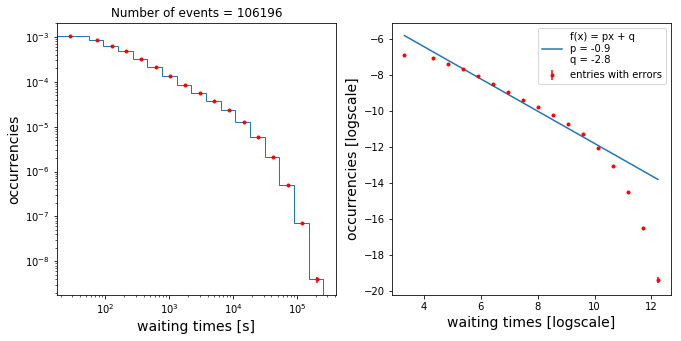


Time distribution for m =  2.25 

Bin extremes number chosen:  17
All frequencies are non-zero :  True
Good points 12 out of 16


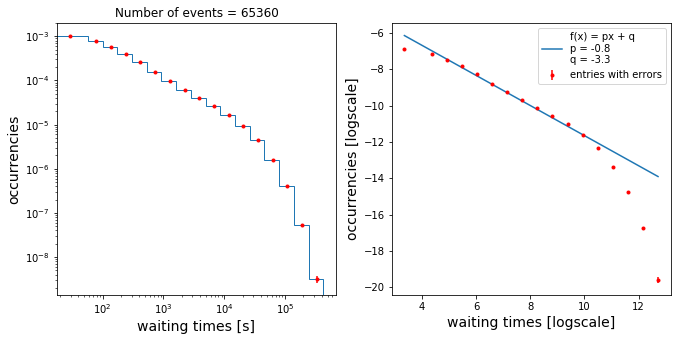


Time distribution for m =  2.5 

Bin extremes number chosen:  17
All frequencies are non-zero :  True
Good points 13 out of 16


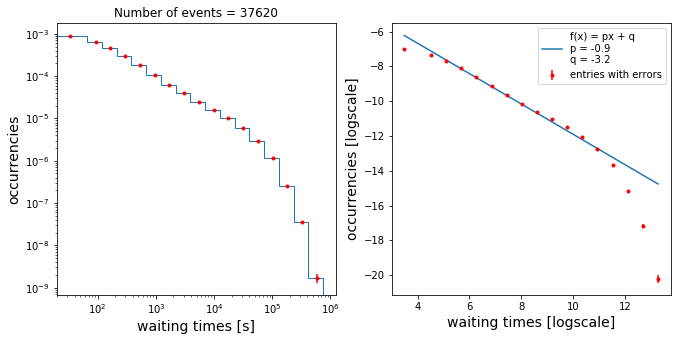


Time distribution for m =  2.75 

Bin extremes number chosen:  17
All frequencies are non-zero :  True
Good points 13 out of 16


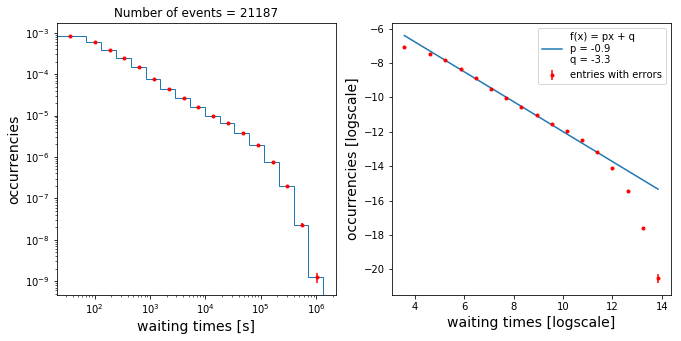


Time distribution for m =  3.0 

Bin extremes number chosen:  17
All frequencies are non-zero :  True
Good points 14 out of 16


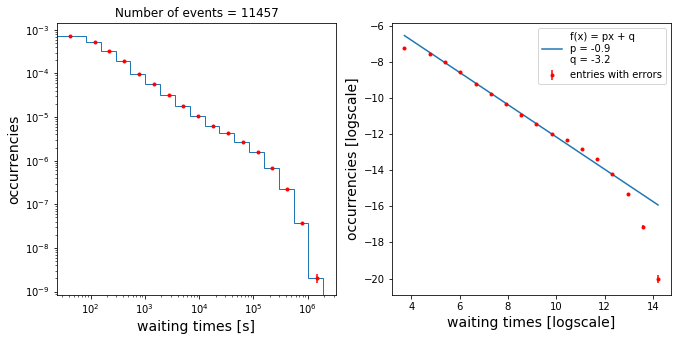


Time distribution for m =  3.25 

Bin extremes number chosen:  17
All frequencies are non-zero :  True
Good points 14 out of 16


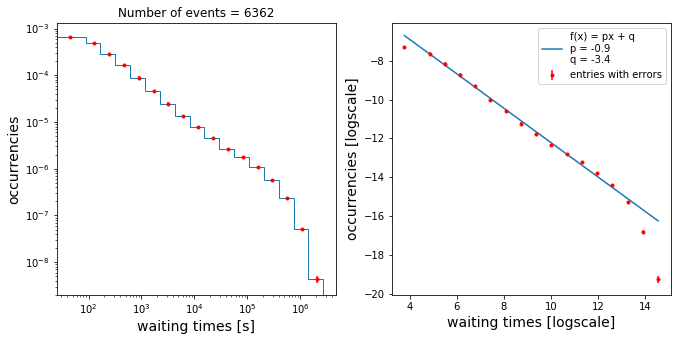


Time distribution for m =  3.5 

Bin extremes number chosen:  16
All frequencies are non-zero :  True
Good points 14 out of 15


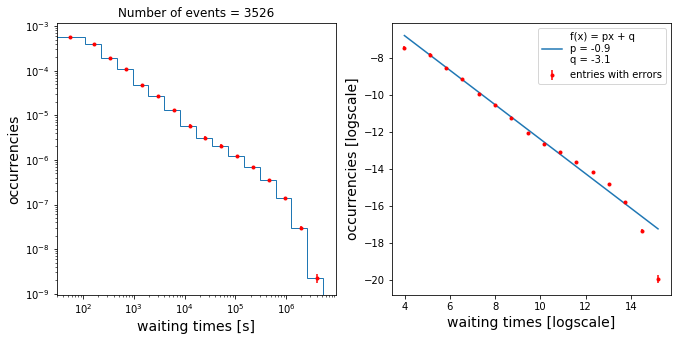


Time distribution for m =  3.75 

Bin extremes number chosen:  15
All frequencies are non-zero :  True
Good points 13 out of 14


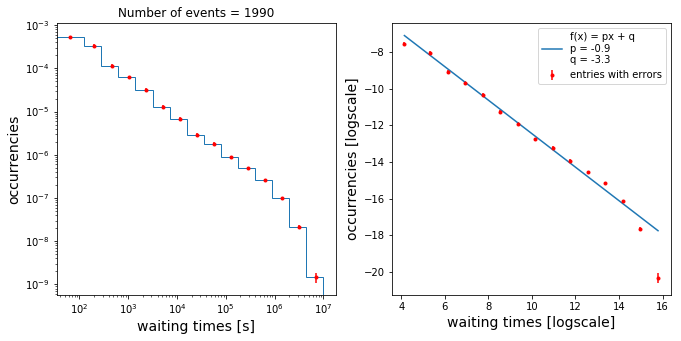


Time distribution for m =  4.0 

Bin extremes number chosen:  14
All frequencies are non-zero :  True
Good points 12 out of 13


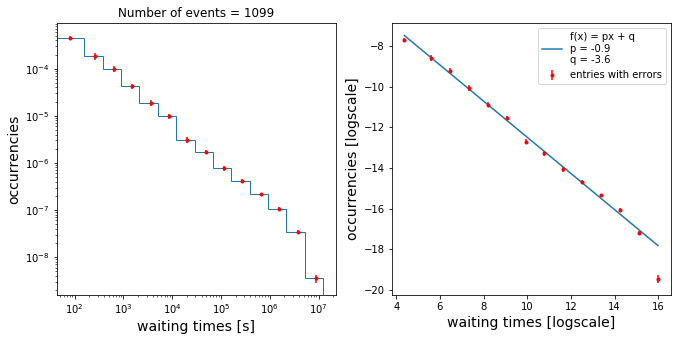


Time distribution for m =  4.25 

Bin extremes number chosen:  12
All frequencies are non-zero :  True
Good points 10 out of 11


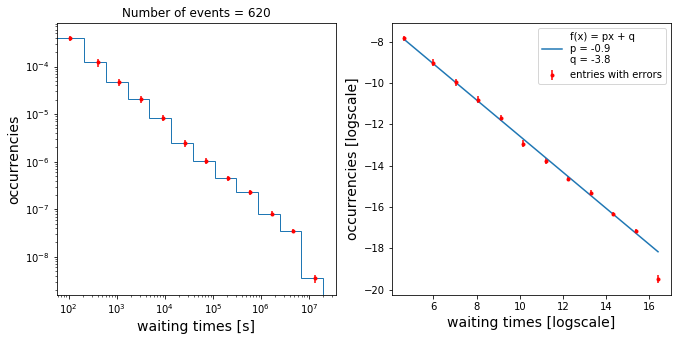


Time distribution for m =  4.5 

Bin extremes number chosen:  11
All frequencies are non-zero :  True
Good points 9 out of 10


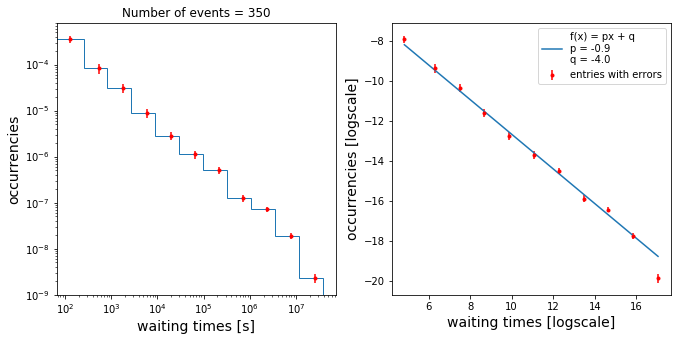

In [258]:
# we choose to study the data for m between 2 and 4.5, because above 5 we get just 104 samples 
# and there isn't enough information to fit anything but the initial peak of the distribution.
ms1 = np.linspace(2,4.5,11)
p_time = np.zeros(len(ms1))
q_time = np.zeros(len(ms1))
p_t_errors = np.zeros(len(ms1))
cut_times = np.zeros(len(ms1))

for i in range(len(ms1)):

    m = ms1[i]
    print('\nTime distribution for m = ', m, '\n')
    # waiting time for events of magnitude > m
    dfm = df[df['magnitude'] > m]
    timem = np.array(dfm['time'])
    timem.sort()
    time_d = timem[1:] - timem[:-1]
    
    # eliminating a couple of anomalous events
    temp = time_d[time_d != time_d.max()]
    maximum = temp.max()
    if time_d.max()*3/4 > maximum:
        time_d = temp

    p_time[i], q_time[i], p_t_errors[i], cut_times[i] = plot_powerlaw_hist(time_d, rescaling = False, 
                                                                   density = True, cut_off = True, P0 = 5)

### 2.1 - Scaling of the exponent as a function of m

Distribution considered:

$P_{m>\bar{m}}(t_w) = At_w^{-\alpha(\bar{m})}$,

where $\alpha = -p$ and A is just a normalization constant.

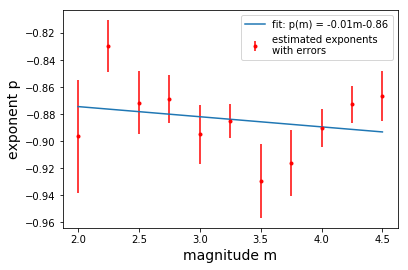

In [259]:
# we can see how the exponent is a linear funcion of m
#print(ms, ps1)
#ms = ms[:-2]
#ps1 = ps1[:-2]
#p_errors = p_errors[:-2]

slope, intercept, r_value, p_value, std_err = stats.linregress(ms1, p_time)
plt.errorbar(ms1, p_time, yerr = p_t_errors, fmt = '.r', label = 'estimated exponents \nwith errors' )
plt.plot(ms1, intercept+slope*ms1, label = 'fit: p(m) = %.2fm%.2f'%(slope,intercept))
#plt.title('Dipendence on magnitude of the exponent p')
plt.ylabel('exponent p', fontsize = 14)
plt.xlabel('magnitude m', fontsize = 14)
plt.legend()
plt.show()

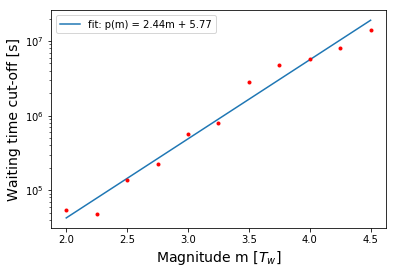

In [270]:
slope, intercept, r_value, p_value, std_err = stats.linregress(ms1, np.log(cut_times))
predicted_cut_times = np.exp(intercept+slope*ms1)
plt.plot(ms1, predicted_cut_times, label = 'fit: p(m) = %.2fm + %.2f'%(slope,intercept))

plt.errorbar(ms1, cut_times, fmt = '.r')
#plt.title('Dipendence on magnitude of the exponent p')
plt.ylabel('Waiting time cut-off [s]', fontsize = 14)
plt.xlabel('Magnitude m [$T_w$]', fontsize = 14)
plt.yscale('log')
plt.legend()
#print(cut_times)
plt.show()


Scaling of the cut-off as a function of magnitude.

If we rescale the times for $t_m = e^{\beta m + \alpha}$ we will obtain a unique distribution for all the magnitudes.

### 2.2 - Waiting time distribution between concatenated events

We now analyze the distribution of waiting times but considering only the waiting times between an event and the ancestor.


In general we expect a greater exponent $\alpha$ of $P_{m>\bar{m}}(t_w) = At_w^{-\alpha(\bar{m})}$ because we consider much more correlated pairs of event than in the previous case.

In [52]:
time_diff_tree = np.zeros(N)

for d in range(len(v_dict)):
    for k in v_dict[d].keys():
        # previous vertex has id = k, children vertexes have ids [ v_dict[d][k] ]
        for j in v_dict[d][k]:
            #print('Computing {}-> {} waiting time.'.format(k,j))
            time_diff_tree[int(j)] = df['time'].iloc[int(j)] - df['time'].iloc[int(k)]
            
time_diff_tree = time_diff_tree[time_diff_tree > 0]

Bin extremes number chosen:  17
All frequencies are non-zero :  True
Good points 13 out of 16


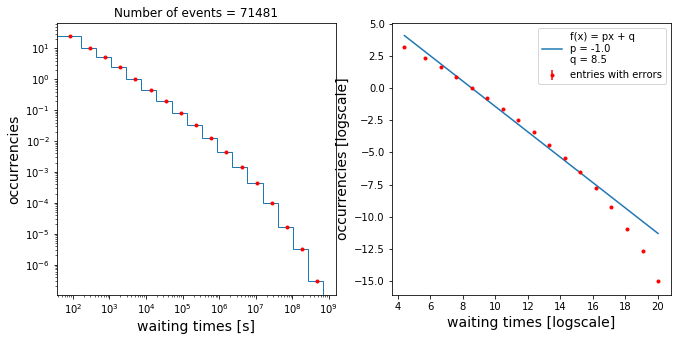

In [73]:
p_tree, q_tree, p_tree_err, cut_time_tree = plot_powerlaw_hist(time_diff_tree, rescaling = False, 
                                                                   density = False, cut_off = True)

We can see that the waiting time distribution of consequent events displaces a behaviour similar to the more general case seen above, i.e. a power law with a cut-off. 


Time distribution for m =  2.0 

Bin extremes number chosen:  17
All frequencies are non-zero :  False
Entered in the while loop
Original frequencies:  [2.185e+03 1.063e+03 1.624e+03 2.310e+03 3.107e+03 3.943e+03 4.814e+03
 5.273e+03 5.062e+03 3.953e+03 2.419e+03 1.074e+03 2.900e+02 3.500e+01
 2.000e+00 0.000e+00 0.000e+00]
Merging bin 15 (empty) with bin 14.
Entered in the while loop
Original frequencies:  [2.185e+03 1.063e+03 1.624e+03 2.310e+03 3.107e+03 3.943e+03 4.814e+03
 5.273e+03 5.062e+03 3.953e+03 2.419e+03 1.074e+03 2.900e+02 3.500e+01
 2.000e+00 0.000e+00]
Merging bin 15 (empty) with bin 14.
Good points 3 out of 14


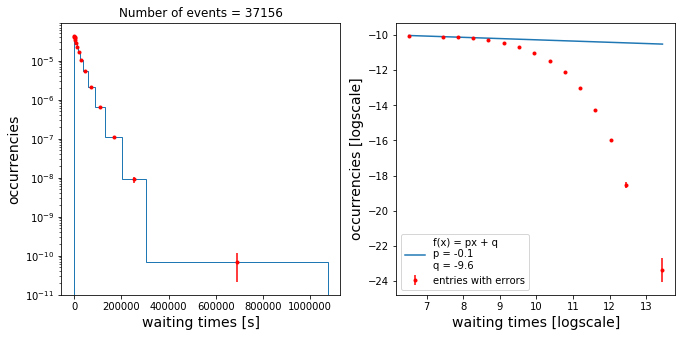


Time distribution for m =  2.2222222222222223 

Bin extremes number chosen:  17
Merging first and second bins.
All frequencies are non-zero :  False
Entered in the while loop
Original frequencies:  [2.078e+03 9.540e+02 1.271e+03 1.761e+03 2.250e+03 2.682e+03 3.132e+03
 3.101e+03 2.615e+03 2.006e+03 1.176e+03 4.740e+02 1.260e+02 2.100e+01
 2.000e+00 0.000e+00]
Merging bin 15 (empty) with bin 14.
Good points 4 out of 14


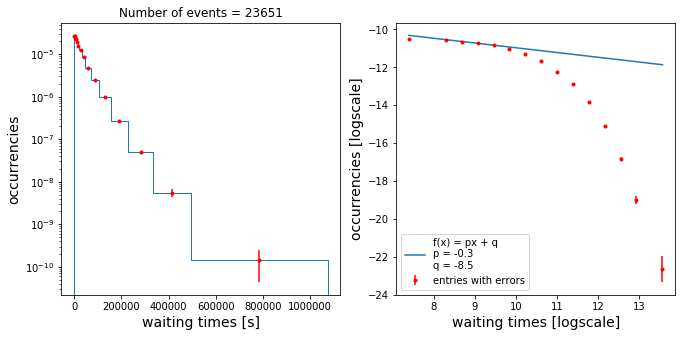


Time distribution for m =  2.4444444444444446 

Bin extremes number chosen:  17
Merging first and second bins.
All frequencies are non-zero :  True
Good points 3 out of 15


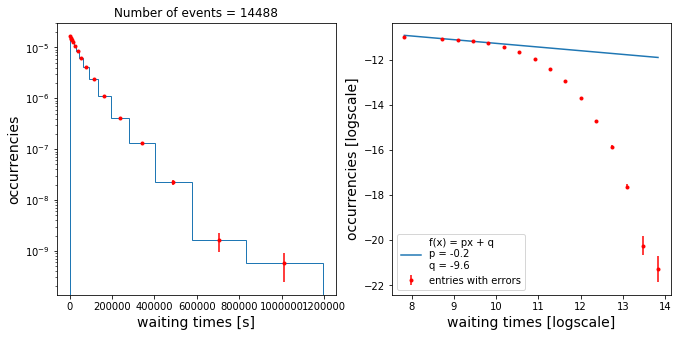


Time distribution for m =  2.6666666666666665 

Bin extremes number chosen:  17
All frequencies are non-zero :  True
Good points 3 out of 16


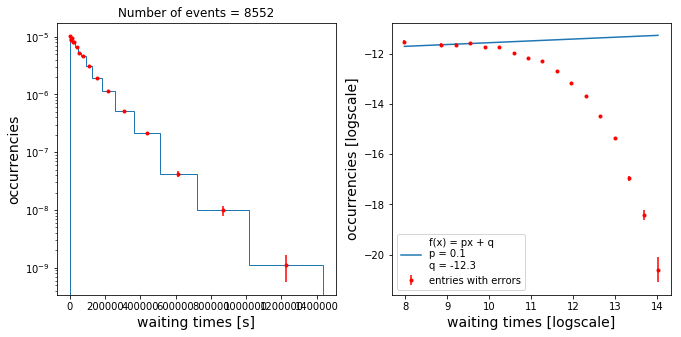


Time distribution for m =  2.888888888888889 

Bin extremes number chosen:  16
All frequencies are non-zero :  True
Good points 8 out of 15


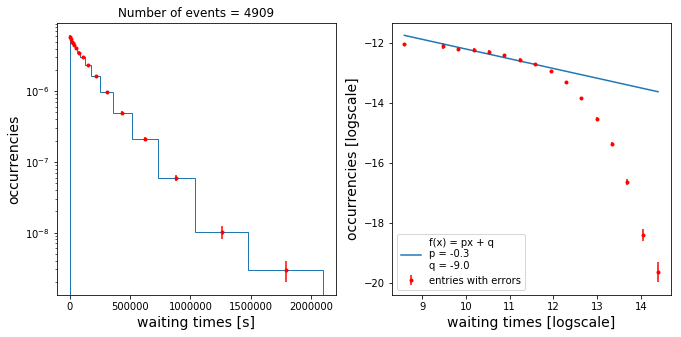


Time distribution for m =  3.111111111111111 

Bin extremes number chosen:  15
All frequencies are non-zero :  True
Good points 9 out of 14


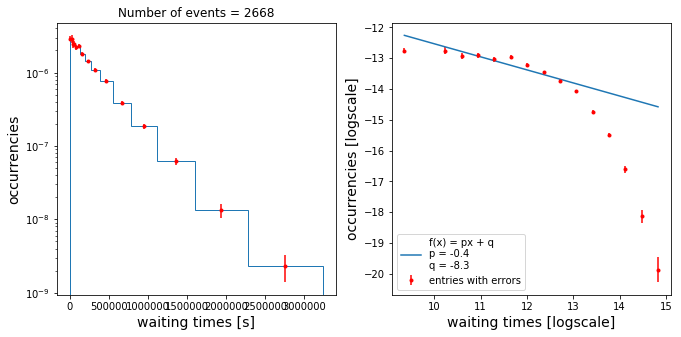


Time distribution for m =  3.333333333333333 

Bin extremes number chosen:  14
All frequencies are non-zero :  True
Good points 10 out of 13


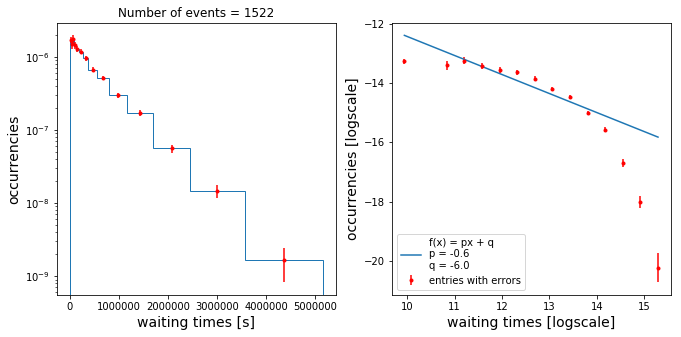


Time distribution for m =  3.5555555555555554 

Bin extremes number chosen:  13
All frequencies are non-zero :  True
Good points 3 out of 12


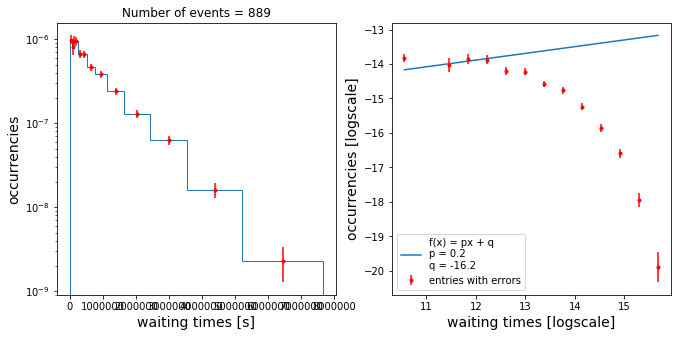


Time distribution for m =  3.7777777777777777 

Bin extremes number chosen:  12
Merging first and second bins.
All frequencies are non-zero :  True
Good points 7 out of 10


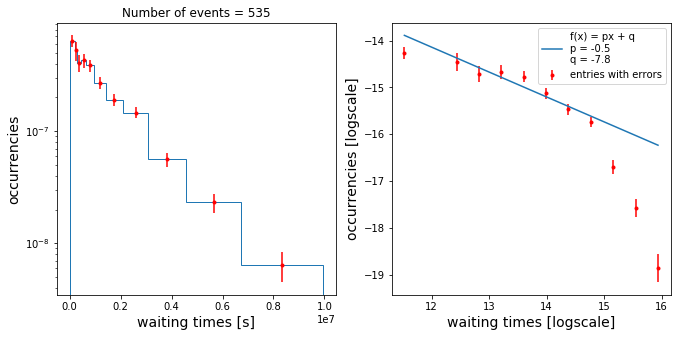


Time distribution for m =  4.0 

Bin extremes number chosen:  11
All frequencies are non-zero :  True
Good points 3 out of 10


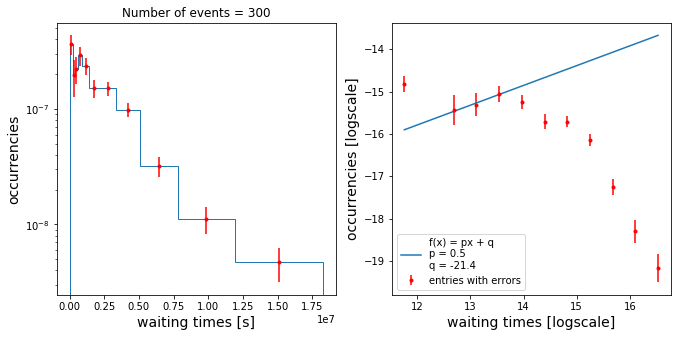

In [167]:
# we choose to study the data for m between 2 and 4.5, because above 5 we get just 104 samples 
# and there isn't enough information to fit anything but the initial peak of the distribution.
ms = np.linspace(2,4,10)
p_time_prime = np.zeros(len(ms))
q_time_prime = np.zeros(len(ms))
p_t_errors_prime = np.zeros(len(ms))
cut_times_prime = np.zeros(len(ms))

for i in range(len(ms)):

    m = ms[i]
    print('\nTime distribution for m = ', m, '\n')
    # waiting time for events of magnitude > m
    dfm_pr = df[(df['magnitude'] > m) & (df['prev_event'] == -1)]
    timem = np.array(dfm_pr['time'])
    timem.sort()
    time_d = timem[1:] - timem[:-1]
    
    # eliminating a couple of anomalous events
    temp = time_d[time_d != time_d.max()]
    maximum = temp.max()
    if time_d.max()*3/4 > maximum:
        time_d = temp
# COULD BE INTERESTING, BUT IS AN EXTRA PART
    p_time_prime[i], q_time_prime[i], p_t_errors_prime[i], cut_times_prime[i] = plot_powerlaw_hist(time_d, rescaling = False, 
                                                                   density = True, cut_off = True, P0 = 3)

# 3 - Distance distribution between events

Compute the distribution $P_m(r)$ of the distance between an event and the next one, considering earthquakes of magnitude m or above. Also here make a clever choice for the bin sizes and try several values of $m$.

In [104]:
# REMOVE
def binning_dist(x, rescaling = False, density = False):
    
    """Binning for power laws distributions.
        x = entries generated from a power law."""
    
    # x must have streactly positive values; x isn't normalized in general
    x = x[x>0]
    if rescaling == True:
        x = x/x.max()
        
    x.sort()
    # empirical method to get a good amount of bins (min 8), depending on the number of samples
    bin_extremes_number = max( min( int( np.log(len(x)) ) , 21), 9) 
    print('Bin extremes number chosen: ', bin_extremes_number )
    first_quantile = x[int(x.shape[0]*(0.3/bin_extremes_number))]
    #print('First quantile: ', first_quantile)
    bin_extremes = np.logspace(np.log10(first_quantile), np.log10(x.max()), bin_extremes_number)
    bin_extremes = np.concatenate((np.array([0]), bin_extremes))

    widths = bin_extremes[1:] - bin_extremes[:-1]
    centers = (bin_extremes[1:] + bin_extremes[:-1])/2
    
    freq, _, _ = plt.hist(x, bins=bin_extremes)
    plt.close()
    
    # weights(bin_center) = Prob(bin_center) if normalized
    weights = freq/widths
    sigma_weights = np.sqrt(freq)/widths
    """
    # merging of the first two bins until we get that the first bin represents the max of the PDF
    while weights[0] < weights[1]:
        print('Merging first and second bins.')
        #this is done by removing the second extreme, thus the first bin becomes the one between 0 and 2
        bin_extremes = np.concatenate(([bin_extremes[0]], bin_extremes[2:] ))
        widths = bin_extremes[1:] - bin_extremes[:-1]
        centers = (bin_extremes[1:] + bin_extremes[:-1])/2

        freq, _, _ = plt.hist(x, bins=bin_extremes)
        plt.close()
        weights = freq/widths
        sigma_weights = np.sqrt(freq)/widths
    """  
    # adding also the merging of empty bins with the one on the left
    # rewrite it in a better form
    mask = (freq != np.zeros(len(freq)))
    flag = np.all(mask)
    print('All frequencies are non-zero : ', flag)
    # should enter in the while loop only in there is at least one bin without counts in it
    
    while flag == False:
        print('Entered in the while loop')
        print('Original frequencies: ', freq)
        for i in range(1,len(freq)):
            if freq[i] == 0:
                print('Merging bin {} (empty) with bin {}.'.format(i,i-1))
                # bin extremes should be of length len(freq) + 1
                # notice that bin_extremes[i] corresponds to the right border of bin[i-1]
                # bin_extremes[:i] excludes the bin_extreme[i] !
                bin_extremes = np.concatenate((bin_extremes[:i], bin_extremes[i+1:] ))
                widths = bin_extremes[1:] - bin_extremes[:-1]
                centers = (bin_extremes[1:] + bin_extremes[:-1])/2
                # call a break of the for because the len frequence changes and can result in index errors
                break
                
        # update of the frequencies

        freq, _, _ = plt.hist(x, bins=bin_extremes)
        plt.close()
        weights = freq/widths
        sigma_weights = np.sqrt(freq)/widths
        
        mask = (freq != np.zeros(len(freq)))
        flag = np.all(mask)
 
    if density == True:
        #returns normalized weights (with rescaled errors) so that the area of the histogram is 1
        area = np.sum(weights*widths)
        weights = weights / area
        sigma_weights = sigma_weights/area
    
    return bin_extremes, widths, centers, freq, weights, sigma_weights   

In [105]:
# REMOVE
def plot_powerlaw_hist_distance(x, rescaling = False, density = False, **kwargs):
    
    bin_extremes, widths, centers, freq, weights, sigma_weights = binning_dist(x, rescaling, density)
    bin_number = len(centers)
    
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2,figsize=(11, 5))
        
    ax1.hist(centers, bins = bin_extremes, weights = weights, histtype = 'step')
    ax1.errorbar(centers, weights, sigma_weights, fmt = 'r.')
    ax1.set_xscale('log')
    #ax1.set_yscale('log')
    ax1.set_xlabel('distances [m]', fontsize = 14)
    ax1.set_ylabel('occurrencies', fontsize = 14)
    ax1.set_title('Number of events = {}'.format(len(x)))
    
    # now we need to fit the power law in the log-log space, eventually identifying the points before the cut-off
    # this should work automatically both for the case rescaling = True or False (if True, x is in [0,1]) 
    # and for the case density = True or False (if True, the area of the histogram is normalized to 1 
    # and the weights are rescaled so that np.sum(weights*bin_widths) = 1)
    log_x = np.log(centers)
    log_w = np.log(weights)
    
    # the idea is to write a function that as a default just fits the (log_x,log_w) with a linear function 
    # log_w = p*log_x + q and has 2 flags: one for excluding skip_initial_pt points (set to 1 for default because
    # the first bin is always problematic) and another one to signal that we expect a cut-off at the right side of the
    # distribution (i.e. the tail) and we want to stop fitting just before the cut-off.
    # we want as a return the parameters p and q with their covariance matrix (that is the default return of 
    # scipy curve_fit) and, if the cut_off flag is True, also the estimate cut-off (rescaled or not depending on the 
    # setting passed before)
    
    if 'cut_off' in kwargs:
        if kwargs['cut_off'] == True:
             p, q, cov, log_x_cut = loglog_fitting(log_x, log_w, **kwargs)
    else:
        p, q, cov = loglog_fitting(log_x, log_w, **kwargs)
    
    # those errors are wrong!
    #y_errors = 1./np.sqrt(weights)
    #should be
    y_errors = sigma_weights/weights
    
    ax2.errorbar(log_x, log_w, yerr = y_errors ,fmt ='r.', label = 'entries with errors')
    ax2.plot(log_x, linear_f(log_x, p, q), 
             label = 'f(x) = px + q\np = {} \nq = {}'.format(round(p,1),round(q,1)))
    ax2.legend()
    ax2.set_xlabel('distances [logscale]', fontsize = 14)
    ax2.set_ylabel('occurrencies [logscale]', fontsize = 14)
    
    plt.show()
    
    if 'cut_off' in kwargs:
        if kwargs['cut_off'] == True:
            if rescaling == True:
                return p, q, np.sqrt(cov[0,0]), np.exp(log_x_cut)*x.max()
            else:
                return p, q, np.sqrt(cov[0,0]), np.exp(log_x_cut)
    else:
        # returns the slope, the intercept and the error of the slope
        return p, q, np.sqrt(cov[0,0])


Distance distribution for m =  2.0 

Bin extremes number chosen:  10
All frequencies are non-zero :  True
Good points 6 out of 9


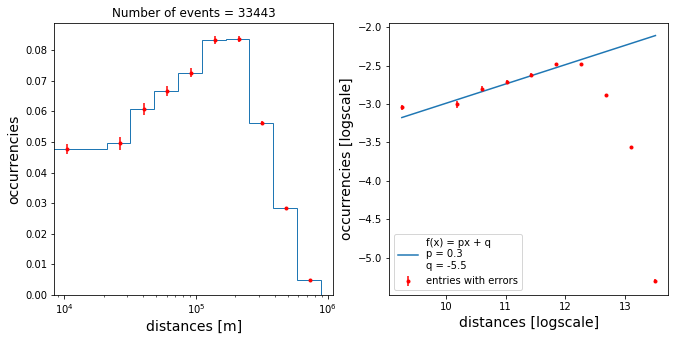


Distance distribution for m =  2.4 

Bin extremes number chosen:  9
All frequencies are non-zero :  True
Good points 6 out of 8


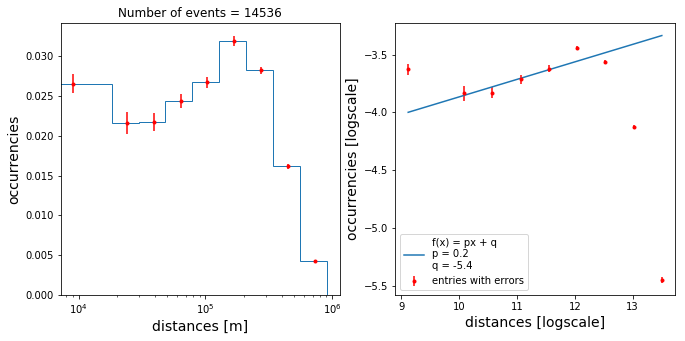


Distance distribution for m =  2.8 

Bin extremes number chosen:  9
All frequencies are non-zero :  True
Good points 7 out of 8


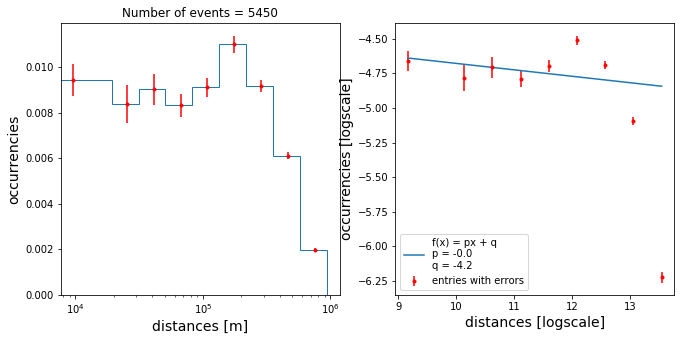


Distance distribution for m =  3.2 

Bin extremes number chosen:  9
All frequencies are non-zero :  True
Good points 7 out of 8


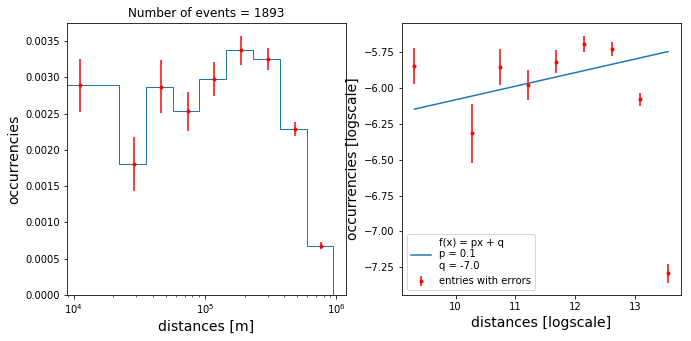


Distance distribution for m =  3.6 

Bin extremes number chosen:  9
All frequencies are non-zero :  True
Good points 7 out of 8


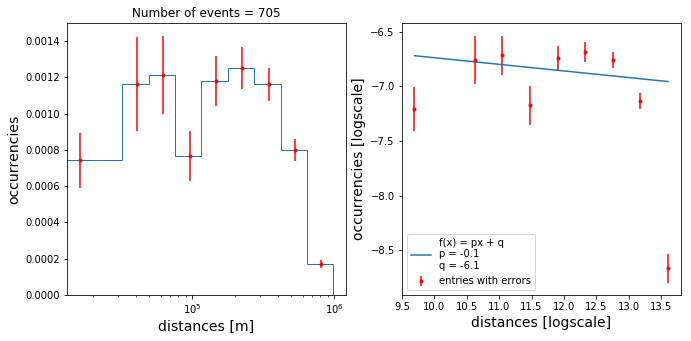


Distance distribution for m =  4.0 

Bin extremes number chosen:  9
All frequencies are non-zero :  True
Good points 7 out of 8


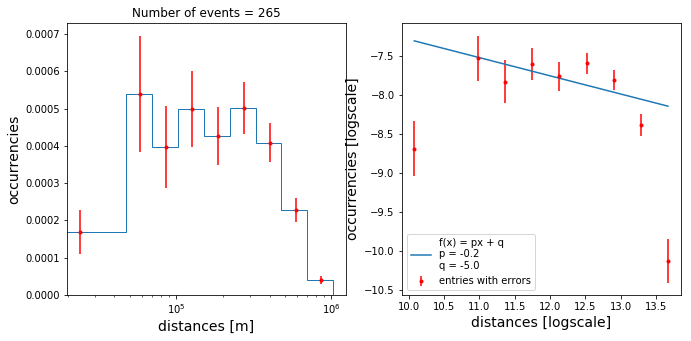

In [106]:
# REMOVE
ms = np.linspace(2,4,6)
p_dist = np.zeros(len(ms))
q_dist = np.zeros(len(ms))
p_d_errors = np.zeros(len(ms))
cut_dist = np.zeros(len(ms))


for i in range(len(ms)):
    m = ms[i]
    print('\nDistance distribution for m = ', m, '\n')
    prime_df = df[df['prev_event'] == -1]
    dfm = prime_df[(prime_df['magnitude'] > m) & (prime_df['magnitude'] < m+1)]
    X = np.array(dfm[['x','y','z']])
    r = np.linalg.norm(X[1:]-X[:-1], axis = 1)
    p_dist[i], q_dist[i], p_d_errors[i], cut_dist[i] = plot_powerlaw_hist_distance(r, rescaling = False, 
                                                        density = False, cut_off = True)

In [36]:
def plot_Pm_r2(m, df):
    print('\nDistance distribution for m = ', m, '\n')
    dfm = df[df['magnitude'] > m]
    X = np.array(dfm[['x','y','z']])
    r = np.linalg.norm(X[1:]-X[:-1], axis = 1)
    r_norm = r/r.max()
    #r_norm = r_norm[r_norm<0.00040]
    # computing suitable sizes of bins
    #bin_extremes, widths, centers, freq, weights = select_bin_number_mod_mod(r_norm, m = m, sensibility = 0.03)
    original_bin_number, bins = select_bin_number_mod(r_norm, m=m, min_nbin = 10)
    #bin_number = len(centers)
    bin_number = len(bins) - 1
    
    fig, ax1 = plt.subplots(nrows=1, ncols=1,figsize=(6, 5))
    
    n_tailed, bin_extremes, _ = ax1.hist(r_norm, bins = bins, histtype = 'step')
    # ax1.hist(centers, bins = bin_extremes, weights = weights, histtype = 'step')

    bin_centers = (bin_extremes[:-1] + bin_extremes[1:])/2
    
    # rescaling the tail entries with the number of bins merged into the tail 
    # -> it's not fair, the rescaling should depend on the distribution expected
    n = np.concatenate((n_tailed[:-1], n_tailed[-1:]/(original_bin_number+1-bin_number)))
    
    sigma_n = np.sqrt(n)
    #sigma_weights = np.sqrt(freq)/widths
    
    ax1.errorbar(bin_centers, n, sigma_n, fmt = 'r.')
    #ax1.errorbar(r_norm, weights, sigma_weights, fmt = 'r.')
    
    ax1.set_xlabel('normalized distances', fontsize = 14)
    ax1.set_ylabel('occurrencies', fontsize = 14)
    ax1.set_title('Number of events = {}'.format(len(r_norm)))
    #x1.set_xscale('log')
    #x1.set_yscale('log')
    #print('Number of bins merged into the tail: {}'.format(original_bin_number - bin_number), '\n')

    plt.show()
    plt.close()
    return r.mean(), r.std()/np.sqrt(len(r))


Distance distribution for m =  2.0 

For m = 2.0 and N = 106197 the minimum number of events in the tail required is : 106
Minimum accuracy expected : 0.9


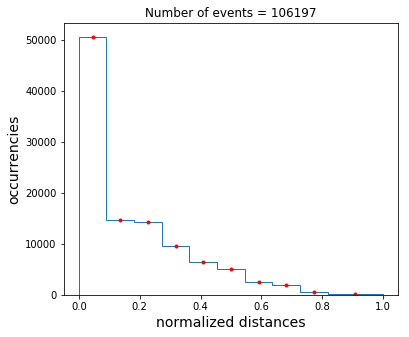


Distance distribution for m =  2.5 

For m = 2.5 and N = 37621 the minimum number of events in the tail required is : 62
Minimum accuracy expected : 0.87


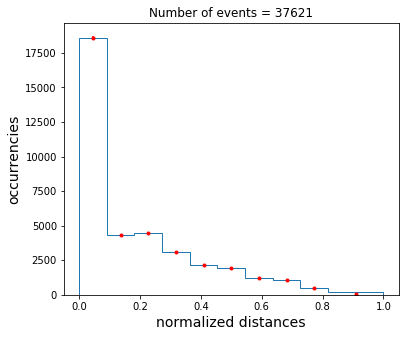


Distance distribution for m =  3.0 

For m = 3.0 and N = 11457 the minimum number of events in the tail required is : 31
Minimum accuracy expected : 0.82


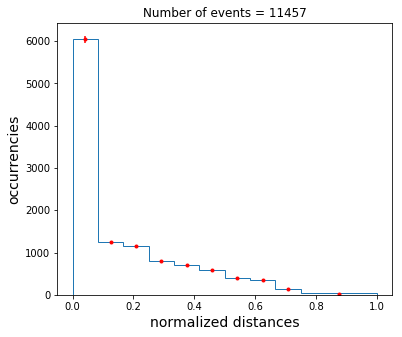


Distance distribution for m =  3.5 

For m = 3.5 and N = 3526 the minimum number of events in the tail required is : 15
Minimum accuracy expected : 0.74


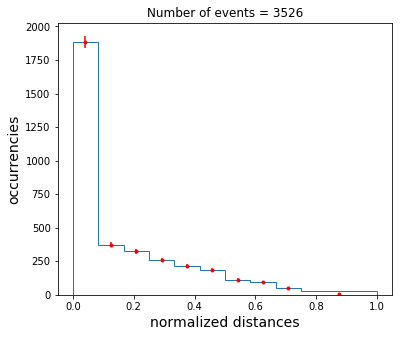


Distance distribution for m =  4.0 

For m = 4.0 and N = 1099 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68


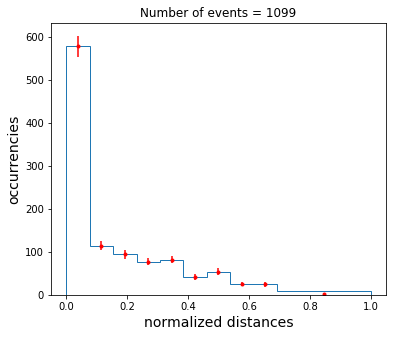


Distance distribution for m =  4.5 

For m = 4.5 and N = 350 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 9: 

For m = 4.5 and N = 350 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 8: 

For m = 4.5 and N = 350 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 7: 

For m = 4.5 and N = 350 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 6: 

For m = 4.5 and N = 350 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 5: 

For m = 4.5 and N = 350 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68


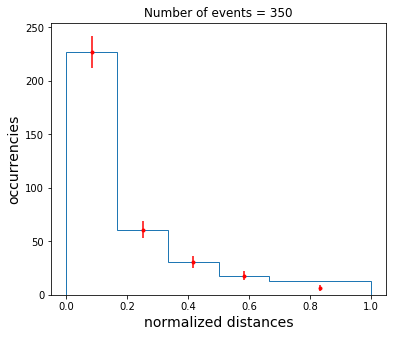

In [37]:
ms = np.linspace(2,4.5,6)

r_mean = np.zeros(len(ms))
r_std = np.zeros(len(ms))

for i in range(len(ms)):
    m = ms[i]
    r_mean[i], r_std[i] = plot_Pm_r2(m, df)
    #plot_Pm_r2(m, df)

## Distance distribution decomposition

The distributions that can be seen above can't be easily identified with a known distribution, thus we decomposed it in two different contributions using our knowledge about how the earthquakes relate one to each other. In fact they can be studied as a sequence of independent events (the ones with prev_event = -1), each one of them causing a cluster of related events, as we have already seen in the study of the tree architecture of the dataset.

Thus we expect that the overall distance distribution is the result of the following process:
* each earthquake has a magnitude distributed as $P(m) \propto e^{-am}$, $a > 0$;
* each earthquake causes N events depending on his magnitude with distibution $N(m) = N_0e^{\gamma m}$, $\gamma > 0$;
* prime events are independent one from another and are distributed with a certain distance distribution $P'_m(r)$;
* consequent events (i.e. all the events that are not prime) have a distance r from the event that caused them, that is distributed with another distribution $P^{cons}(r)$ (here we drop the m-dependence, because a threshold on m is going to breake the chain of cause-effect, that is univoque);

This four distributions, if known, could reproduce the probability distribution of the distance between two "following" events; thus in this section we are going to study $P'_m(r)$ and $P^{cons}(r).$

## 3.1 - Distance distribution between prime events

In [38]:
def poissonian4(x, A=1, l=1):
    from scipy.special import gamma
    return A*np.float_power(l,x)/gamma(x)*np.exp(-l)

import scipy.stats as st
from scipy.integrate import quad

class my_pdf(st.rv_continuous):
    def _pdf(self,x, A, l):
        return poissonian4(x, A, l)  # Normalized over its range, in this case [0,1]

In [39]:
def plot_Pm_r_poisson(m, df):
    print('\nDistance distribution for m = ', m, '\n')
    dfm = df[df['magnitude'] > m]
    X = np.array(dfm[['x','y','z']])
    r = np.linalg.norm(X[1:]-X[:-1], axis = 1)
    r_norm = r/r.max()
    
    
    # computing suitable sizes of bins
    original_bin_number, bins = select_bin_number_mod(r_norm, m=m, min_nbin = 10)
    
    bin_number = len(bins) - 1
    
    fig, ax1 = plt.subplots(nrows=1, ncols=1,figsize=(6, 5))
    
    n_tailed, bin_extremes, _  = ax1.hist(r_norm, bins = bins, histtype = 'step', density=True)
    
    bin_centers = (bin_extremes[:-1] + bin_extremes[1:])/2
    area = len(r)*(bin_extremes[1] - bin_extremes[0])
    # rescaling the tail entries with the number of bins merged into the tail 
    # -> it's not fair, the rescaling should depend on the distribution expected
    n = np.concatenate((n_tailed[:-1], n_tailed[-1:]/(original_bin_number+1-bin_number)))
    
    sigma_n = np.sqrt(n/area)
    ax1.errorbar(bin_centers, n, sigma_n, fmt = 'r.', label = 'entries with \npoissonian errors')
    ax1.set_xlabel('normalized distances', fontsize = 14)
    ax1.set_ylabel('occurrencies', fontsize = 14)
    ax1.set_title('Number of events = {}'.format(len(r_norm)))
    
    print('Number of bins merged into the tail: {}'.format(original_bin_number - bin_number), '\n')

    print('bin_centers: ', bin_centers, '\n')
    params1, cov1 = optimize.curve_fit(poissonian4, bin_centers, n, p0 = [n[0], 1])
    [A,l] = params1

    Area = quad(poissonian4, 0, 1, args=(A, l))[0]
    my_cv = my_pdf(a=0, b=1)
    
    C = A/Area
    
    x_axis = np.linspace(bin_extremes[0], bin_extremes[-1],100)
    ax1.plot(x_axis, my_cv.pdf(x_axis, A=C, l=l), label = 'poissonian \n $\lambda$ = %.3f '%l)
    x_expected = my_cv.expect(args=(C, l))
    x_err = r_norm.std()/np.sqrt(len(r))
    ax1.axvline(x_expected, label = 'expected value = %.2f'%x_expected)
    
    ax1.legend()
    plt.show()
    plt.close()
    
    #expected value, parameters of the poissonian
    return C, l, x_expected, x_err, r.max()

We plotted for each magnitude the normalized distances between two events and fitted them with a continuous Poisson distribution, that is usually used for independent event with a well-defined expected value.


Distance distribution for m =  2.0 

For m = 2.0 and N = 37157 the minimum number of events in the tail required is : 37
Minimum accuracy expected : 0.84
Number of bins merged into the tail: 1 

bin_centers:  [0.04546371 0.13637193 0.22728015 0.31818836 0.40909658 0.5000048
 0.59091302 0.68182124 0.77272945 0.90909178] 



/home/mango/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in float_power
  This is separate from the ipykernel package so we can avoid doing imports until


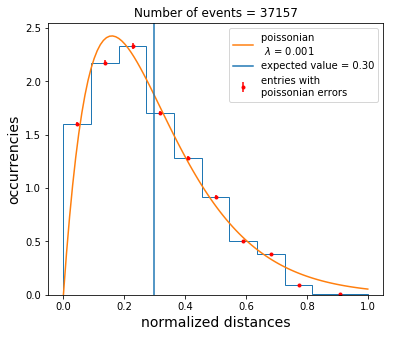


Distance distribution for m =  2.25 

For m = 2.25 and N = 22268 the minimum number of events in the tail required is : 28
Minimum accuracy expected : 0.81
Number of bins merged into the tail: 1 

bin_centers:  [0.04546371 0.13637193 0.22728015 0.31818836 0.40909658 0.5000048
 0.59091302 0.68182124 0.77272945 0.90909178] 



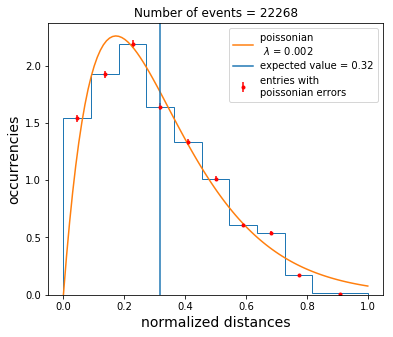


Distance distribution for m =  2.5 

For m = 2.5 and N = 12482 the minimum number of events in the tail required is : 20
Minimum accuracy expected : 0.78
Number of bins merged into the tail: 1 

bin_centers:  [0.0455508  0.13645072 0.22735065 0.31825057 0.40915049 0.50005042
 0.59095034 0.68185027 0.77275019 0.90910008] 



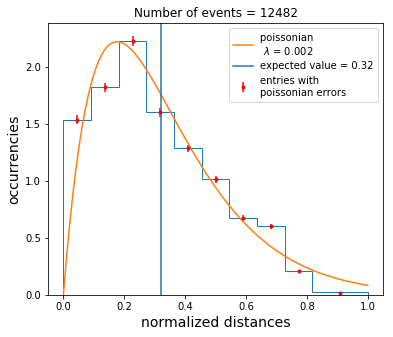


Distance distribution for m =  2.75 

For m = 2.75 and N = 6848 the minimum number of events in the tail required is : 14
Minimum accuracy expected : 0.73
Number of bins merged into the tail: 1 

bin_centers:  [0.04574358 0.13662514 0.2275067  0.31838827 0.40926983 0.5001514
 0.59103296 0.68191453 0.77279609 0.90911844] 



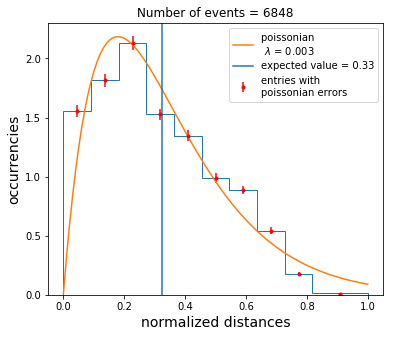


Distance distribution for m =  3.0 

For m = 3.0 and N = 3567 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
Number of bins merged into the tail: 1 

bin_centers:  [0.04574358 0.13662514 0.2275067  0.31838827 0.40926983 0.5001514
 0.59103296 0.68191453 0.77279609 0.90911844] 



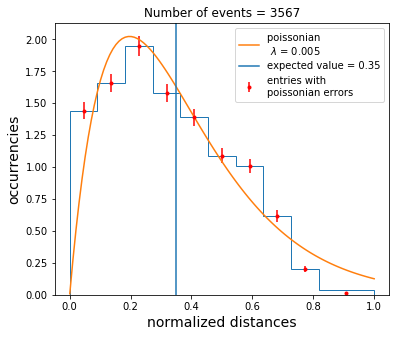


Distance distribution for m =  3.25 

For m = 3.25 and N = 1866 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
Number of bins merged into the tail: 1 

bin_centers:  [0.04618399 0.13702361 0.22786323 0.31870285 0.40954247 0.50038209
 0.59122171 0.68206133 0.77290095 0.90916038] 



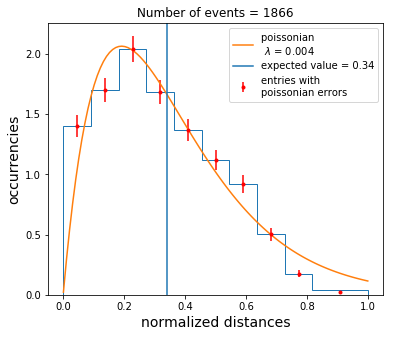


Distance distribution for m =  3.5 

For m = 3.5 and N = 993 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
Number of bins merged into the tail: 1 

bin_centers:  [0.04966685 0.14017477 0.23068269 0.32119061 0.41169853 0.50220645
 0.59271437 0.68322228 0.7737302  0.90949208] 



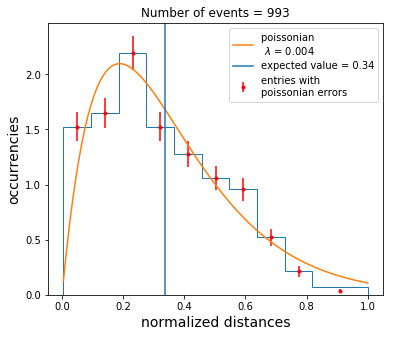


Distance distribution for m =  3.75 

For m = 3.75 and N = 555 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
Number of bins merged into the tail: 2 

bin_centers:  [0.04656914 0.12947617 0.2123832  0.29529023 0.37819726 0.4611043
 0.54401133 0.62691836 0.70982539 0.87563945] 



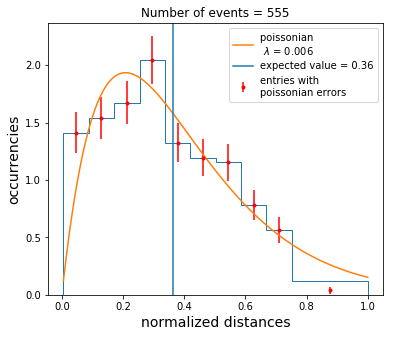


Distance distribution for m =  4.0 

For m = 4.0 and N = 300 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
Number of bins merged into the tail: 3 

bin_centers:  [0.05138108 0.1272706  0.20316011 0.27904962 0.35493914 0.43082865
 0.50671816 0.58260768 0.65849719 0.84822097] 



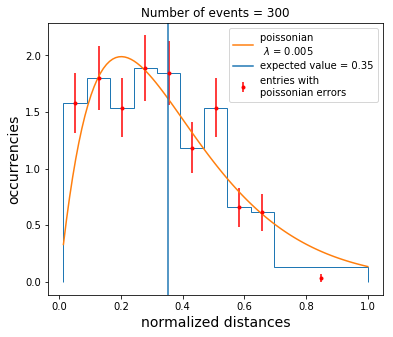

In [40]:
prime_df = df[df['prev_event'] == -1]
# reduced the range of m to [2,4] due to insufficient samples for higher magnitudes
pr_ms = np.linspace(2,4,9)

pr_Cs = np.zeros(len(pr_ms))
pr_ls_r = np.zeros(len(pr_ms))
pr_r_expected = np.zeros(len(pr_ms))
pr_r_exp_err = np.zeros(len(pr_ms))
pr_r_max = np.zeros(len(pr_ms))


for i in range(len(pr_ms)):
    m = pr_ms[i]
    pr_Cs[i], pr_ls_r[i], pr_r_expected[i], pr_r_exp_err[i], pr_r_max[i] = plot_Pm_r_poisson(m, prime_df)

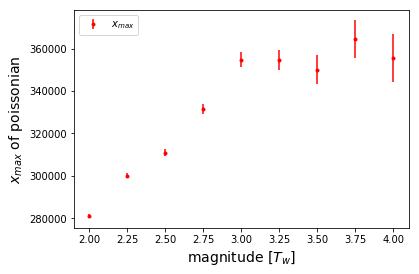

In [41]:
rescaled_peaks = pr_r_expected*pr_r_max
rescaled_errors = pr_r_exp_err*pr_r_max
plt.errorbar(pr_ms, rescaled_peaks, rescaled_errors, fmt = 'r.', label = '$x_{max}$')
plt.xlabel('magnitude [$T_w$]', fontsize = 14)
plt.ylabel('$x_{max}$ of poissonian', fontsize = 14)
plt.legend(loc = 2)
plt.show()

In the graph we can see that the expected value of the distance between two events grows linearly as a function of the magnitude until $m = 3.0$, where there is a plateau, indicating some kind of saturation effect. 

## 3.2 - Distance distribution between consequent events

In [151]:
distance_tree = np.zeros(N)

for d in range(len(v_dict)):
    for k in v_dict[d].keys():
        # previous vertex has id = k, children vertexes have ids [ v_dict[d][k] ]
        for j in v_dict[d][k]:
            distance_tree[int(j)] = np.linalg.norm(df[['x','y','z']].iloc[int(j)] - df[['x','y','z']].iloc[int(k)])
            
distance_tree = distance_tree[distance_tree > 0]

In [152]:
# we want now to analyse the core of the distribution, neglecting the tail for the moment
print('Max distance: ', distance_tree.max())
dist_truncated = distance_tree[distance_tree < 100000]
samples_discarded = len(distance_tree)-len(dist_truncated)
percentage_discarded = samples_discarded / len(distance_tree)
print('Number of samples discarded : {} ({}%)'.format(samples_discarded, round(percentage_discarded*100,1)))

Max distance:  622385.861082978
Number of samples discarded : 837 (1.2%)


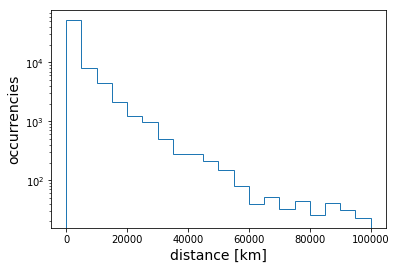

In [158]:
n, bins, _ = plt.hist(dist_truncated, bins = 20, histtype = 'step')
plt.xlabel('distance [km]', fontsize = 14)
plt.ylabel('occurrencies', fontsize = 14)
plt.yscale('log')
plt.show()

Bin extremes number chosen:  17
Merging first and second bins.
All frequencies are non-zero :  True
Good points 10 out of 15


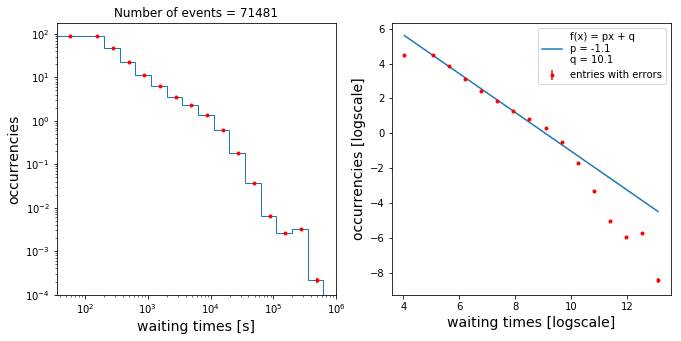

(-1.1142523298314724, 10.10819168141148, 0.04061575257050637, 36721.5670592461)

In [156]:
# MUCH BETTER THAN CAUCHY
plot_powerlaw_hist(distance_tree, rescaling = False, density = False, cut_off = True)

This distribution is characterized by a decrease that is more than exponential in the first part and then has a long tail that is non-neglegible. Furthermore using the logscale in the y axis we can see that the exponent of the distribution is a convex function of the distance. This considerations lead us to model the distribution as a Cauchy distribution 
$P(r) = \frac{1}{\pi D_r}(1 + \frac{r^2}{D_r^2})^{-1}$
with a typical displacement $D_r$, that in principle should depend on the characteristic waiting time between two events, but we take it just as a parameter. 

In [45]:
def log_cauchy_distribution(x, a, D_x):
    return a - np.log(1 + np.power(x/D_x,2))

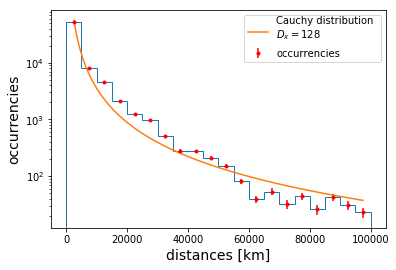

In [46]:
bin_number = 20
n, bins, _ = plt.hist(dist_truncated, bins = bin_number)
plt.close()
bin_centers = (bins[:-1] + bins[1:])/2
params1, cov1 = optimize.curve_fit(log_cauchy_distribution, bin_centers, np.log(n), p0 = [np.log(n[0]), 100])
[a,D_x] = params1
D_x_err = np.sqrt(np.diag(cov1)[1])

x_axis = np.linspace(bin_centers[0], bin_centers[-1],100)
plt.hist(dist_truncated, bins = bin_number, histtype = 'step')
plt.plot(x_axis, np.exp(log_cauchy_distribution(x_axis,*params1)), 
         label = 'Cauchy distribution \n$D_x = %.0f$'%(D_x))
plt.errorbar(bin_centers, n, yerr = np.sqrt(n), fmt = 'r.', label = 'occurrencies')
plt.xlabel('distances [km]', fontsize = 14)
plt.ylabel('occurrencies', fontsize = 14)
plt.yscale('log')
plt.legend()
plt.show()
plt.close()


This is interesting because the Cauchy distribution is characterized by a pronounced peak around the 0, but hasn't a defined variance, thus, even though most of the events will be close one to another, there will be a non-neglegible percentage of events with a much greater distance. 

## 4 - Range-conditioned waiting time distribution

Compute the distribution $P_{m,R}(t)$ of waiting times for events of magnitude $m$ or above, which are separated by at most a distance $r<R$, for different values of m and $R$. (In this statistics, if the following event is farther than $R$, skip the $t$ and go to the next pair)

In [234]:
# Function to plot waiting times with R condition (fixed m_min)

def Pm_t_Rcondition(df, m, R_fractions):
    #print('m = ', m, '\n')
    
    # distance and waiting times between events of magnitude > m
    dfm = df[df['magnitude'] > m]
    dfm = dfm.set_index(np.arange(len(dfm)))
    X = np.array(dfm[['x','y','z']])
    r = np.linalg.norm(X[1:]-X[:-1], axis = 1)
    timem = np.array(dfm['time'])
    timem.sort()
    time_d = timem[1:] - timem[:-1]
    
    #vector for fit parameters for each R_max fraction
    ps = []
    qs = []
    p_errors = [] 
    Rs = np.power(np.linspace(np.sqrt(0.1),1,R_fractions),2)
    print('R_max fractions considered: ', Rs, '\n')
    #Repeat plots and fits for each R_max fraction
    # fra code
    #for i in range(1, R_fractions+1):
    for i in range(R_fractions):
        # building the mask to filter "distances < R" and apply that to original waiting times
        print("R_max = "+str(i+1)+"/"+str(R_fractions)+" * max_distance")
        # linearly spaced fractions - fra code
        #R_mask = pd.Series(np.concatenate((np.array([True]), r <= i/R_fractions*r.max())))
        R_mask = pd.Series(np.concatenate((np.array([True]), r <= Rs[i]*r.max())))
        dfmr = dfm[R_mask]
        r_norm = r[R_mask[1:]]/r.max()  
        time_diff = time_d[R_mask[1:]]/time_d.max()
        print("{} events hav been removed ({}%)\n"\
              .format(len(dfm)-len(dfmr), round(100*(1-(len(dfmr)/len(dfm))),2)))
 
        # computing suitable sizes of bins
        original_bin_number, bins = select_bin_number_mod(time_diff, m = m)
        bin_number = len(bins) - 1

        n_tailed, bin_extremes, _  = plt.hist(time_diff, bins = bins, histtype = 'step')

        bin_centers = (bin_extremes[:-1] + bin_extremes[1:])/2

         # rescaling the tail entries with the number of bins merged into the tail 
        # -> it's not fair, the rescaling should depend on the distribution expected
        n = np.concatenate((n_tailed[:-1], n_tailed[-1:]/(original_bin_number+1-bin_number)))

        # linear fit over the log of the entries
        params1, cov1 = optimize.curve_fit(loglogt, np.log(bin_centers), np.log(n), p0 = [-1,5])
        [p,q] = params1
        var_p = np.diag(cov1)[0]
        print('variance of exponent p = ', var_p)
        plt.close()

        #Add parameters in their lists
        ps.append(p)
        qs.append(q)
        p_errors.append(np.sqrt(var_p))
    return np.array(ps), np.array(qs), np.array(p_errors)

In [235]:
ms = np.linspace(2,4.5,6)
R_fractions = 20
Ps = np.zeros((len(ms),R_fractions))
Qs = np.zeros((len(ms),R_fractions))
P_errors = np.zeros((len(ms),R_fractions))

for i in range(len(ms)):
    Ps[i], Qs[i], P_errors[i] = Pm_t_Rcondition(df, ms[i], R_fractions)

R_max fractions considered:  [0.1        0.12405595 0.15070218 0.17993869 0.21176546 0.24618251
 0.28318984 0.32278744 0.36497531 0.40975346 0.45712188 0.50708057
 0.55962954 0.61476879 0.6724983  0.73281809 0.79572816 0.8612285
 0.92931911 1.        ] 

R_max = 1/20 * max_distance
53807 events hav been removed (50.67%)




NameError: name 'select_bin_number_mod' is not defined

In [111]:
def plot_PmR_t(df, m, Rs, n=100, **kwargs):
    print('\nTime distribution for m = ', m, '\n')
    # waiting time for events of magnitude > m
    #Xp = np.dot(Vt,X) # last coordinate should be small
    #Xpp = np.dot(U, Xp)
    centers = np.dot(U, np.array([np.random.uniform(-3,4, n), np.random.uniform(-2,2, n), np.zeros(n)])).T
    dfm = df[df['magnitude'] > m]

    X = dfm[['x','y','z']].values.T
    X = X.astype("float64")
    # centering and rescaling the coordinates
    for i in range(3):
        X[i] = (X[i] - X[i].mean())/X[i].std()

    distances = np.linalg.norm((X.T[:,np.newaxis,:] - centers[np.newaxis,:,:]), axis=2)
    distances = distances / distances.max()
    print("Max distance : ", distances.max())
    timem = np.array(dfm['time'])
    timeM = np.tile(timem[:, np.newaxis], [1,n]).T
    
    #vector for fit parameters for each R_max fraction
    ps = []
    qs = []
    p_errors = [] 
    cut_off_times = []
    
    for i in range(len(Rs)):
        #print(timeM.shape)

        timeM_filtered = timeM[distances.T < Rs[i]]
        #print(timeM.shape)
        #print(distances.T.shape)
        time_d = (timeM_filtered[1:] - timeM_filtered[:-1])
        time_d = time_d[time_d>0]
        
        p, q, p_err, cut_times = plot_powerlaw_hist(time_d, **kwargs )
        
        ps.append(p); qs.append(q); p_errors.append(p_err), cut_off_times.append(cut_times)
        
    return ps, qs, p_errors, cut_off_times

In [236]:
from tqdm import tqdm_notebook, tnrange
import time
R_fractions = 20
ms = np.arange(2,4.6,0.1)
Rs = np.power(np.linspace(np.sqrt(0.1),1,R_fractions),2)
Ps = np.zeros((len(ms),R_fractions))
Qs = np.zeros((len(ms),R_fractions))
P_errors = np.zeros((len(ms),R_fractions))
t_cutoff = np.zeros((len(ms),R_fractions))

for i in tnrange(len(ms)):
    
    Ps[i], Qs[i], P_errors[i], t_cutoff[i] = plot_PmR_t(df, ms[i], Rs, cut_off = True, P0 = 5, show = False )


Time distribution for m =  2.0 

Max distance :  1.0
Bin extremes number chosen:  17
All frequencies are non-zero :  True
Good points 9 out of 16
Bin extremes number chosen:  17
All frequencies are non-zero :  True
Good points 9 out of 16
Bin extremes number chosen:  17
All frequencies are non-zero :  True
Good points 8 out of 16
Bin extremes number chosen:  17
All frequencies are non-zero :  True
Good points 8 out of 16
Bin extremes number chosen:  17
All frequencies are non-zero :  True
Good points 8 out of 16
Bin extremes number chosen:  17
All frequencies are non-zero :  False
Entered in the while loop
Original frequencies:  [2.34828e+05 2.06191e+05 2.75774e+05 3.28219e+05 3.43364e+05 3.61615e+05
 4.03770e+05 4.54464e+05 4.87095e+05 4.36862e+05 2.90672e+05 1.27877e+05
 3.45890e+04 5.25400e+03 6.12000e+02 3.70000e+01 0.00000e+00]
Merging bin 16 (empty) with bin 15.
Good points 9 out of 15
Bin extremes number chosen:  17
All frequencies are non-zero :  True
Good points 11 out of 16


Bin extremes number chosen:  17
All frequencies are non-zero :  True
Good points 11 out of 16
Bin extremes number chosen:  17
All frequencies are non-zero :  True
Good points 11 out of 16
Bin extremes number chosen:  17
All frequencies are non-zero :  True
Good points 11 out of 16
Bin extremes number chosen:  17
All frequencies are non-zero :  True
Good points 11 out of 16
Bin extremes number chosen:  17
All frequencies are non-zero :  True
Good points 11 out of 16
Bin extremes number chosen:  17
All frequencies are non-zero :  True
Good points 11 out of 16
Bin extremes number chosen:  17
All frequencies are non-zero :  True
Good points 11 out of 16
Bin extremes number chosen:  17
All frequencies are non-zero :  True
Good points 11 out of 16
Bin extremes number chosen:  17
All frequencies are non-zero :  True
Good points 11 out of 16
Bin extremes number chosen:  17
All frequencies are non-zero :  True
Good points 11 out of 16
Bin extremes number chosen:  17
All frequencies are non-zero

Max distance :  1.0
Bin extremes number chosen:  17
All frequencies are non-zero :  True
Good points 10 out of 16
Bin extremes number chosen:  17
All frequencies are non-zero :  True
Good points 10 out of 16
Bin extremes number chosen:  17
All frequencies are non-zero :  True
Good points 9 out of 16
Bin extremes number chosen:  17
All frequencies are non-zero :  True
Good points 10 out of 16
Bin extremes number chosen:  17
All frequencies are non-zero :  True
Good points 10 out of 16
Bin extremes number chosen:  17
All frequencies are non-zero :  True
Good points 10 out of 16
Bin extremes number chosen:  17
All frequencies are non-zero :  True
Good points 11 out of 16
Bin extremes number chosen:  17
All frequencies are non-zero :  True
Good points 11 out of 16
Bin extremes number chosen:  17
All frequencies are non-zero :  True
Good points 12 out of 16
Bin extremes number chosen:  17
All frequencies are non-zero :  True
Good points 12 out of 16
Bin extremes number chosen:  17
All frequ

All frequencies are non-zero :  True
Good points 11 out of 16
Bin extremes number chosen:  17
All frequencies are non-zero :  True
Good points 13 out of 16
Bin extremes number chosen:  17
All frequencies are non-zero :  True
Good points 12 out of 16
Bin extremes number chosen:  17
All frequencies are non-zero :  True
Good points 13 out of 16
Bin extremes number chosen:  17
All frequencies are non-zero :  True
Good points 13 out of 16
Bin extremes number chosen:  17
All frequencies are non-zero :  True
Good points 13 out of 16
Bin extremes number chosen:  17
All frequencies are non-zero :  True
Good points 13 out of 16
Bin extremes number chosen:  17
All frequencies are non-zero :  True
Good points 13 out of 16
Bin extremes number chosen:  17
All frequencies are non-zero :  True
Good points 13 out of 16
Bin extremes number chosen:  17
All frequencies are non-zero :  True
Good points 14 out of 16
Bin extremes number chosen:  17
All frequencies are non-zero :  True
Good points 14 out of 1

All frequencies are non-zero :  True
Good points 13 out of 16
Bin extremes number chosen:  17
All frequencies are non-zero :  True
Good points 13 out of 16
Bin extremes number chosen:  17
All frequencies are non-zero :  True
Good points 13 out of 16
Bin extremes number chosen:  17
All frequencies are non-zero :  True
Good points 13 out of 16
Bin extremes number chosen:  17
All frequencies are non-zero :  True
Good points 15 out of 16
Bin extremes number chosen:  17
All frequencies are non-zero :  True
Good points 14 out of 16
Bin extremes number chosen:  17
All frequencies are non-zero :  True
Good points 15 out of 16
Bin extremes number chosen:  17
All frequencies are non-zero :  True
Good points 15 out of 16
Bin extremes number chosen:  17
All frequencies are non-zero :  True
Good points 15 out of 16
Bin extremes number chosen:  17
All frequencies are non-zero :  True
Good points 15 out of 16
Bin extremes number chosen:  17
All frequencies are non-zero :  True
Good points 15 out of 1

All frequencies are non-zero :  True
Good points 15 out of 16
Bin extremes number chosen:  17
All frequencies are non-zero :  True
Good points 15 out of 16
Bin extremes number chosen:  17
All frequencies are non-zero :  True
Good points 15 out of 16
Bin extremes number chosen:  17
All frequencies are non-zero :  True
Good points 15 out of 16
Bin extremes number chosen:  17
All frequencies are non-zero :  True
Good points 15 out of 16
Bin extremes number chosen:  17
All frequencies are non-zero :  True
Good points 15 out of 16

Time distribution for m =  3.9000000000000017 

Max distance :  1.0
Bin extremes number chosen:  17
All frequencies are non-zero :  True
Good points 14 out of 16
Bin extremes number chosen:  17
All frequencies are non-zero :  True
Good points 5 out of 16
Bin extremes number chosen:  17
All frequencies are non-zero :  True
Good points 13 out of 16
Bin extremes number chosen:  17
All frequencies are non-zero :  True
Good points 14 out of 16
Bin extremes number chos

All frequencies are non-zero :  True
Good points 14 out of 16
Bin extremes number chosen:  17
All frequencies are non-zero :  True
Good points 15 out of 16
Bin extremes number chosen:  17
All frequencies are non-zero :  True
Good points 15 out of 16
Bin extremes number chosen:  17
All frequencies are non-zero :  True
Good points 14 out of 16
Bin extremes number chosen:  17
All frequencies are non-zero :  True
Good points 14 out of 16
Bin extremes number chosen:  17
All frequencies are non-zero :  True
Good points 14 out of 16
Bin extremes number chosen:  17
All frequencies are non-zero :  True
Good points 15 out of 16
Bin extremes number chosen:  17
All frequencies are non-zero :  True
Good points 15 out of 16
Bin extremes number chosen:  17
All frequencies are non-zero :  True
Good points 15 out of 16
Bin extremes number chosen:  17
All frequencies are non-zero :  True
Good points 15 out of 16
Bin extremes number chosen:  17
All frequencies are non-zero :  True
Good points 15 out of 1

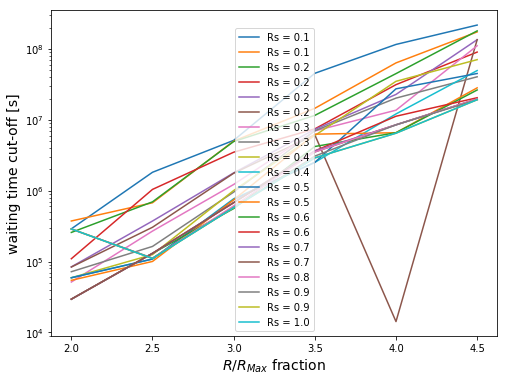

In [206]:
ms = np.linspace(2,4.5,6)
Rs = np.power(np.linspace(np.sqrt(0.1),1,R_fractions),2)
plt.figure(figsize = (8,6))
for i in range(len(Rs)):
    plt.plot(ms, t_cutoff[:,i], label = 'Rs = %.1f'%Rs[i])
plt.legend()
plt.yscale('log')
#plt.xscale('log')
plt.xlabel('$R/R_{Max}$ fraction', fontsize = 14)
plt.ylabel('waiting time cut-off [s]', fontsize = 14)
plt.show()

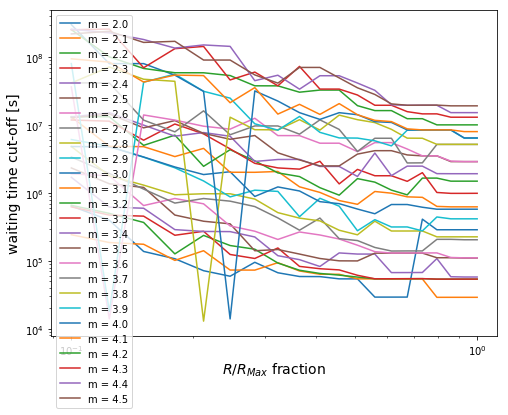

In [237]:
ms = np.arange(2,4.6,0.1)
Rs = np.power(np.linspace(np.sqrt(0.1),1,R_fractions),2)
plt.figure(figsize = (8,6))
for i in range(len(ms)):
    plt.plot(Rs, t_cutoff[i], label = 'm = %.1f'%ms[i])
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.xlabel('$R/R_{Max}$ fraction', fontsize = 14)
plt.ylabel('waiting time cut-off [s]', fontsize = 14)
plt.show()

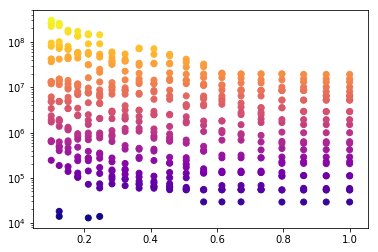

In [238]:
R_axis = np.tile(Rs[:, np.newaxis], [1,ms.shape[0]]).T
m_color = np.tile(ms[:, np.newaxis], [1,Rs.shape[0]])
plt.scatter(R_axis, t_cutoff, c = np.log(t_cutoff), cmap = 'plasma' )
#plt.gray()
plt.yscale('log')

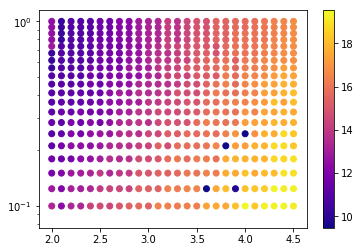

In [240]:
plt.scatter(m_color, R_axis, c = np.log(t_cutoff), cmap = 'plasma')
plt.yscale('log')
plt.colorbar()

In [182]:
t_cutoff.shape

(6, 20)

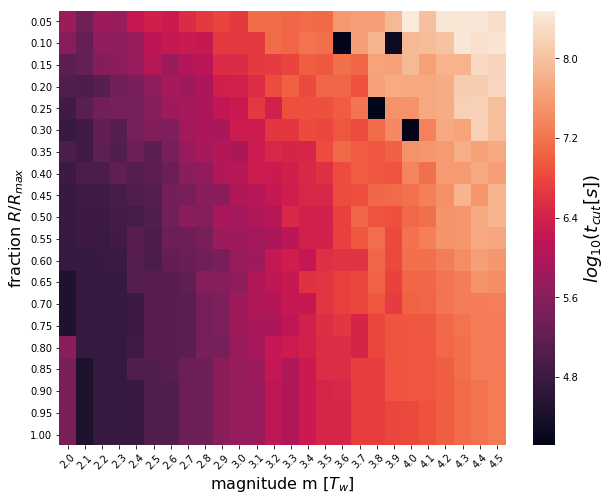

In [256]:
import seaborn as sns
plt.figure(figsize = (10,8))
ax = sns.heatmap(np.log10(t_cutoff).T, annot = False, cbar_kws = {'label' : '$log_{10}(t_{cut}[s]) $'})

m_index = ['%.1f'%m for m in ms]
ax.set_xticklabels(m_index, rotation = 45)
ax.set_xlabel('magnitude m [$T_w$]', fontsize = 16)

R_index = ['%.2f'%((i+1)/20) for i in range(len(Rs))]
ax.set_yticklabels(R_index, rotation = 0)
ax.set_ylabel('fraction $R/R_{max}$', fontsize = 16)

ax.figure.axes[-1].yaxis.label.set_size(18)

plt.show()

From our analysis there isn't a neither a clear nor a signficant dependence of the parameter p of $P_{m,R}(t) = t^p$ (p < 0) from the chosen R.

In order to show that we plot in the left panel the value of p as a function of $\frac{R}{R_{max}}$ (for R that goes from 0.1 $R_{max}$ to $R_{max}$) for each m considered and in the right panel the mean value of p(R,m) (averaged over R) as a function of m and confront it with the prediction for p(m) obtained from $P_m(t)$ in section 2.

We can see that there isn't any clear pattern in the left panel, and that fluctuations tend to decrease as $\frac{R}{R_{max}}$ approaches to 1; Furthermore almost all the average points $p_{mean}(m)$ are compatible within 2 sigmas with the prediction considering all ranges.

# 5 - Scaling properties
Eventually note if, from the analysis of the previous points, there emerges a scaling picture. Is there a suitable rescaling that collapses distributions for various $m$ (and eventually $R$ if point 4 is considered) on a single curve?

## 5.1 - Time scaling with magnitude
First of all we have seen that the exponent $p$ of $P_m(t)$ is linear in m: $p(m) = \alpha + m\beta$

This mean that we can write:  

$P_m(t) = At^{p(m)} = At^{\alpha + m\beta} = P_0(t)t^{m\beta}$

Thus, through the scaling $t_w \rightarrow t_w^{-m\beta}t_w$ we should get the same distribution for the waiting time of events of magnitude > m.

In [ ]:
def collapsed_distributions(x, rescaling = False, density = False, show = True, **kwargs):
    
    bin_extremes, widths, centers, freq, weights, sigma_weights = binning(x, rescaling, density)
    bin_number = len(centers)
    
    if show:
        fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2,figsize=(11, 5))

        ax1.hist(centers, bins = bin_extremes, weights = weights, histtype = 'step')
        ax1.errorbar(centers, weights, sigma_weights, fmt = 'r.')
        ax1.set_xscale('log')
        ax1.set_yscale('log')
        ax1.set_xlabel('waiting times [s]', fontsize = 14)
        ax1.set_ylabel('occurrencies', fontsize = 14)
        ax1.set_title('Number of events = {}'.format(len(x)))
    
    # now we need to fit the power law in the log-log space, eventually identifying the points before the cut-off
    # this should work automatically both for the case rescaling = True or False (if True, x is in [0,1]) 
    # and for the case density = True or False (if True, the area of the histogram is normalized to 1 
    # and the weights are rescaled so that np.sum(weights*bin_widths) = 1)
    log_x = np.log(centers)
    log_w = np.log(weights)
    
    # the idea is to write a function that as a default just fits the (log_x,log_w) with a linear function 
    # log_w = p*log_x + q and has 2 flags: one for excluding skip_initial_pt points (set to 1 for default because
    # the first bin is always problematic) and another one to signal that we expect a cut-off at the right side of the
    # distribution (i.e. the tail) and we want to stop fitting just before the cut-off.
    # we want as a return the parameters p and q with their covariance matrix (that is the default return of 
    # scipy curve_fit) and, if the cut_off flag is True, also the estimate cut-off (rescaled or not depending on the 
    # setting passed before)
    
    if 'cut_off' in kwargs:
        if kwargs['cut_off'] == True:
             p, q, cov, log_x_cut = loglog_fitting(log_x, log_w, **kwargs)
    else:
        p, q, cov = loglog_fitting(log_x, log_w, **kwargs)
    
    if show:
        y_errors = sigma_weights/weights

        ax2.errorbar(log_x, log_w, yerr = y_errors ,fmt ='r.', label = 'entries with errors')
        ax2.plot(log_x, linear_f(log_x, p, q), 
                 label = 'f(x) = px + q\np = {} \nq = {}'.format(round(p,1),round(q,1)))
        ax2.legend()
        ax2.set_xlabel('waiting times [logscale]', fontsize = 14)
        ax2.set_ylabel('occurrencies [logscale]', fontsize = 14)

        plt.show()
    
    if 'cut_off' in kwargs:
        if kwargs['cut_off'] == True:
            if rescaling == True:
                return p, q, np.sqrt(cov[0,0]), np.exp(log_x_cut)*x.max()
            else:
                return p, q, np.sqrt(cov[0,0]), np.exp(log_x_cut)
    else:
        # returns the slope, the intercept and the error of the slope
        return p, q, np.sqrt(cov[0,0])

In [262]:
print(ms1.shape)
print(cut_times.shape)

(11,)
(11,)


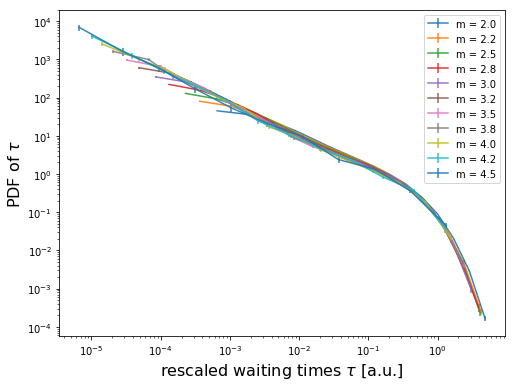

In [288]:
m_centers_rescaled = []
m_weights_rescaled =[]
m_sigma_rescaled = []

for i in range(len(ms1)):

    m = ms1[i]
    dfm = df[df['magnitude'] > m]
    timem = np.array(dfm['time'])
    timem.sort()
    time_d = timem[1:] - timem[:-1]
    
    # eliminating a couple of anomalous events
    temp = time_d[time_d != time_d.max()]
    maximum = temp.max()
    if time_d.max()*3/4 > maximum:
        time_d = temp

    bin_extremes, widths, centers, freq, weights, sigma_weights = binning(time_d, rescaling = False, density = True)
    m_centers_rescaled.append(centers)
    m_weights_rescaled.append(weights)
    m_sigma_rescaled.append(sigma_weights)


plt.figure(figsize = (8,6))
for i in range(len(ms1)):
    centers = m_centers_rescaled[i]/predicted_cut_times[i]
    weights = m_weights_rescaled[i]*predicted_cut_times[i]
    sigma_weights = m_sigma_rescaled[i]*predicted_cut_times[i]
    #centers = m_centers_rescaled[i]/cut_times[i]
    #weights = m_weights_rescaled[i]*cut_times[i]
    #sigma_weights = m_sigma_rescaled[i]*cut_times[i]
    plt.errorbar(centers, weights, yerr = sigma_weights, label = 'm = %.1f'%ms1[i], alpha = 0.9)
plt.xlabel('rescaled waiting times '+r'$\tau$'+' [a.u.]',  fontsize = 16)
plt.ylabel('PDF of '+r'$\tau$', fontsize = 16)
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

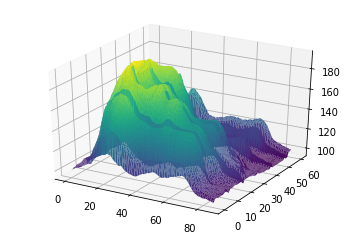

In [289]:
# library
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
 
# Get the data (csv file is hosted on the web)
url = 'https://python-graph-gallery.com/wp-content/uploads/volcano.csv'
data = pd.read_csv(url)
 
# Transform it to a long format
df=data.unstack().reset_index()
df.columns=["X","Y","Z"]
 
# And transform the old column name in something numeric
df['X']=pd.Categorical(df['X'])
df['X']=df['X'].cat.codes
 
# Make the plot
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_trisurf(df['Y'], df['X'], df['Z'], cmap=plt.cm.viridis, linewidth=0.2)
plt.show()
 
# to Add a color bar which maps values to colors.
surf=ax.plot_trisurf(df['Y'], df['X'], df['Z'], cmap=plt.cm.viridis, linewidth=0.2)
fig.colorbar( surf, shrink=0.5, aspect=5)
plt.show()
 
# Rotate it
ax.view_init(30, 45)
plt.show()
 
# Other palette
ax.plot_trisurf(df['Y'], df['X'], df['Z'], cmap=plt.cm.jet, linewidth=0.01)
plt.show()

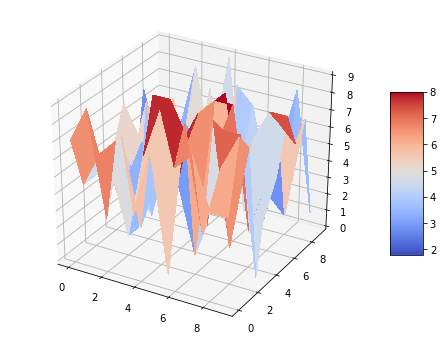

In [304]:
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from mpl_toolkits.mplot3d import Axes3D

x = np.arange(0,10)
y = np.arange(0,10)
X, Y = np.meshgrid(x,y)
Z = np.random.randint(10, size = (10,10))

fig = plt.figure(figsize = (8,6))
ax = fig.gca(projection='3d')

surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

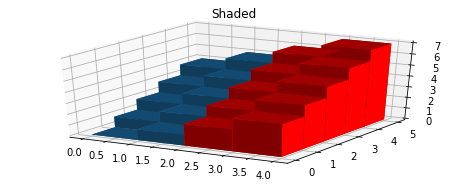

In [319]:
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import


# setup the figure and axes
fig = plt.figure(figsize=(8, 3))
ax = fig.gca(projection='3d')

width = depth = 1
# fake data
_x = np.arange(4)
_y = np.arange(5)
_x = np.array(_x)
_x1 = _x[_x > 1]
_x2 = _x[_x <= 1]
_xx1, _yy1 = np.meshgrid(_x1, _y)
_xx2, _yy2 = np.meshgrid(_x2, _y)
x1, y1 = _xx1.ravel(), _yy1.ravel()
x2, y2 = _xx2.ravel(), _yy2.ravel()
top1 = x1 + y1
bottom1 = np.zeros_like(top1)
top2 = x2 + y2
bottom2 = np.zeros_like(top2)

ax.bar3d(x1, y1, bottom1, width, depth, top1, color = 'r', shade=True)
ax.bar3d(x2, y2, bottom2, width, depth, top2, shade=True)
ax.set_title('Shaded')

plt.show()

In [ ]:
ms1, predicted_cut_times, 

In [312]:
help(ax.bar3d)

Help on method bar3d in module mpl_toolkits.mplot3d.axes3d:

bar3d(x, y, z, dx, dy, dz, color=None, zsort='average', shade=True, *args, **kwargs) method of matplotlib.axes._subplots.Axes3DSubplot instance
    Generate a 3D barplot.
    
    This method creates three dimensional barplot where the width,
    depth, height, and color of the bars can all be uniquely set.
    
    Parameters
    ----------
    x, y, z : array-like
        The coordinates of the anchor point of the bars.
    
    dx, dy, dz : scalar or array-like
        The width, depth, and height of the bars, respectively.
    
    color : sequence of valid color specifications, optional
        The color of the bars can be specified globally or
        individually. This parameter can be:
    
          - A single color value, to color all bars the same color.
          - An array of colors of length N bars, to color each bar
            independently.
          - An array of colors of length 6, to color the faces of the